In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad
import scvelo as scv
import scipy as sp
from scipy import stats
from scipy import special
from scipy.stats import poisson,norm
from scipy.special import j_roots
from scipy.special import beta as beta_fun 
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns

import test.utils as test

In [2]:
scv.set_figure_params(dpi=100, color_map = 'viridis_r')
scv.settings.verbosity = 1
sc.logging.print_header()

scanpy==1.7.2 anndata==0.8.0 umap==0.4.1 numpy==1.19.5 scipy==1.8.0 pandas==1.4.1 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9


In [3]:
# read UMI counts and params for c57 and cast viariants
UMI_c57 = pd.read_csv('data_arme/F1_ref/umiSplit_c57.qc.csv', index_col=0)
UMI_cast = pd.read_csv('data_arme/F1_ref/umiSplit_cast.qc.csv', index_col=0)

UMI = UMI_c57 + UMI_cast

# transpose to ge n_cells x n_genes shape
UMI_c57_T = UMI_c57.transpose(copy=True)
UMI_cast_T = UMI_cast.transpose(copy=True)
UMI_T = UMI.transpose(copy=True)

adata = ad.AnnData(UMI_T)
adata.layers['spliced'] = UMI_c57_T
adata.layers['unspliced'] = UMI_cast_T

gtf = pd.read_csv("data/Mus_musculus.GRCm38.102.chr.gtf", sep='\t', skiprows=5, header=None)
gtf.columns = ['chr', 'database', 'type', 'start', 'end', '.', 'strand', '.', 'other']
gtf = gtf[gtf['type'] == "gene"]
gtf = gtf.reset_index()

dic_gene_names = {}
index = 0
for line in gtf['other'].tolist():
    line = line.split(';')
    dic_gene_names[line[0][9:-1]]= [gtf['chr'][index], line[2][12:-1]]
    index += 1
    
adata.var['gene_name'] = [dic_gene_names[x][1] if x in dic_gene_names.keys() else 'NA' for x in adata.var.index]
adata.var['chromosome'] = [dic_gene_names[x][0] if x in dic_gene_names.keys() else 'NA' for x in adata.var.index]


label = []
for chrom in adata.var['chromosome']:
    if chrom == "X":
        label.append('X')
    elif chrom == "Y":
        label.append('Y')
    else:
        label.append('autosome')
adata.var['autosomes'] = label

label = []
for chrom in adata.var['chromosome']:
    if chrom == "MT":
        label.append('MT')
    else:
        label.append('nuclear')
adata.var['nuclear'] = label

label = []
for genes in adata.var['gene_name']:
    if genes[:2]=='Rp':
        label.append('Ribosomal protein')
    else:
        label.append('other protein')
adata.var['Ribosomal_prot'] = label

test.remove_na(adata)
test.find_ratios_sum(adata)
test.find_ratios_std(adata)

sc.pp.neighbors(adata, n_neighbors=8, n_pcs=31)
sc.tl.umap(adata)
sc.tl.leiden(adata)
adata.obs['clusters'] = adata.obs['leiden'].copy()
               
                           

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [4]:
test.get_p_values(adata)

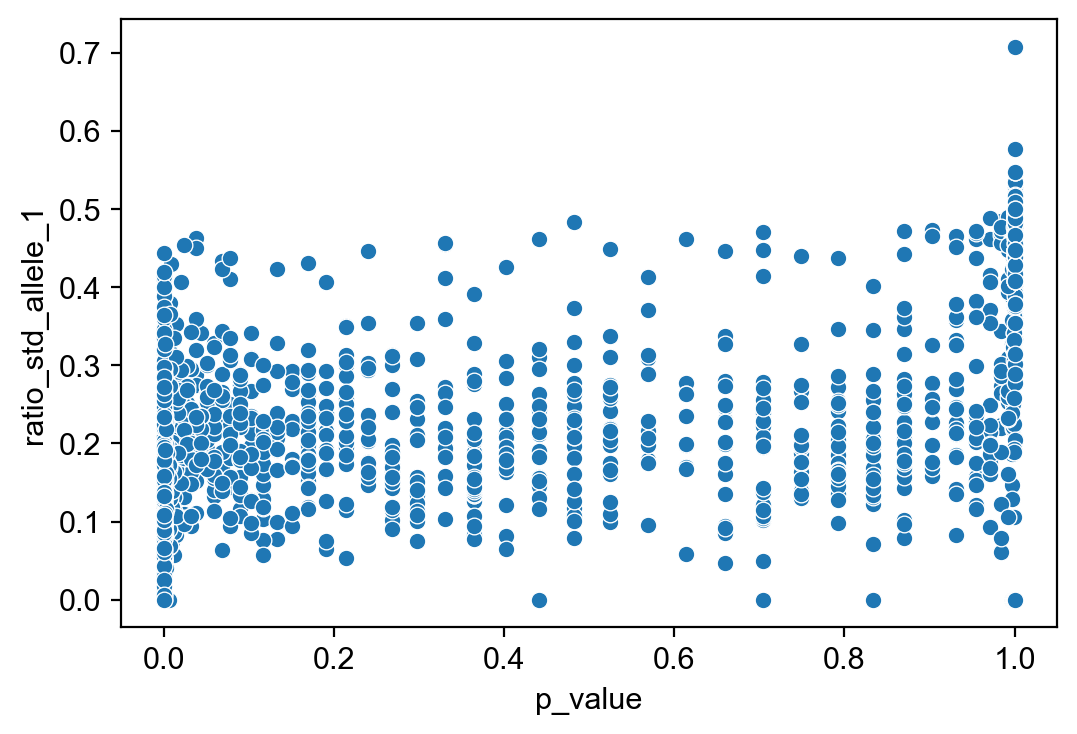

In [5]:
test.sns_scatter(x="p_value", y="ratio_std_allele_1", data=adata.var)

In [6]:
test_df = adata.var[(adata.var['p_value']<0.05) & (adata.var['ratio_std_allele_1']>=0.3)]
test_df

gene_name chromosome autosomes  nuclear  \
ENSMUSG00000004561        Mettl17         14  autosome  nuclear   
ENSMUSG00000005804        Bloc1s6          2  autosome  nuclear   
ENSMUSG00000006763          Saal1          7  autosome  nuclear   
ENSMUSG00000010025        Aldh3a2         11  autosome  nuclear   
ENSMUSG00000017664        Slc35c2          2  autosome  nuclear   
ENSMUSG00000019794         Katna1         10  autosome  nuclear   
ENSMUSG00000020007         Il20ra         10  autosome  nuclear   
ENSMUSG00000020282         Rhbdf1         11  autosome  nuclear   
ENSMUSG00000020305           Asb3         11  autosome  nuclear   
ENSMUSG00000020415          Pttg1         11  autosome  nuclear   
ENSMUSG00000020522          Mfap3         11  autosome  nuclear   
ENSMUSG00000021265       Slc25a29         12  autosome  nuclear   
ENSMUSG00000021428          Riok1         13  autosome  nuclear   
ENSMUSG00000021608         Lpcat1         13  autosome  nuclear   
ENSMUSG00000021619          Atg10         13  autosome  nuclear   
ENSMUSG00000022130           Tgds         14  autosome  nuclear   
ENSMUSG00000022195  6030458C11Rik         15  autosome  nuclear   
ENSMUSG00000022540          Rogdi         16  autosome  nuclear   
ENSMUSG00000022964        Tmem50b         16  autosome  nuclear   
ENSMUSG00000024177           Nme4         17  autosome  nuclear   
ENSMUSG00000025078         Nhlrc2         19  autosome  nuclear   
ENSMUSG00000026181          Ppm1f         16  autosome  nuclear   
ENSMUSG00000027559           Car3          3  autosome  nuclear   
ENSMUSG00000028167           Bdh2          3  autosome  nuclear   
ENSMUSG00000028268           Gbp3          3  autosome  nuclear   
ENSMUSG00000028601         Echdc2          4  autosome  nuclear   
ENSMUSG00000028776        Tinagl1          4  autosome  nuclear   
ENSMUSG00000029007         Agtrap          4  autosome  nuclear   
ENSMUSG00000029387         Gtf2h3          5  autosome  nuclear   
ENSMUSG00000029402        Snrnp35          5  autosome  nuclear   
ENSMUSG00000029500          Pgam5          5  autosome  nuclear   
ENSMUSG00000030284         Creld1          6  autosome  nuclear   
ENSMUSG00000031974         Abcb10          8  autosome  nuclear   
ENSMUSG00000032306            Mpi          9  autosome  nuclear   
ENSMUSG00000033386          Frrs1          3  autosome  nuclear   
ENSMUSG00000039065       Atpsckmt         15  autosome  nuclear   
ENSMUSG00000039917         Rhbdd2          5  autosome  nuclear   
ENSMUSG00000040296          Ddx58          4  autosome  nuclear   
ENSMUSG00000040415           Dtx3         10  autosome  nuclear   
ENSMUSG00000042389          Tsen2          6  autosome  nuclear   
ENSMUSG00000042684            Npl          1  autosome  nuclear   
ENSMUSG00000044881           Coa4          7  autosome  nuclear   
ENSMUSG00000045519         Zfp560          9  autosome  nuclear   
ENSMUSG00000047104           Pbp2          6  autosome  nuclear   
ENSMUSG00000049687         Pheta2         15  autosome  nuclear   
ENSMUSG00000050931          Sgms2          3  autosome  nuclear   
ENSMUSG00000058952            Cfi          3  autosome  nuclear   
ENSMUSG00000059883          Irak4         15  autosome  nuclear   
ENSMUSG00000060519          Tor3a          1  autosome  nuclear   
ENSMUSG00000061313          Ddhd2          8  autosome  nuclear   
ENSMUSG00000063362          Alg11          8  autosome  nuclear   
ENSMUSG00000078768         Zfp566          7  autosome  nuclear   
ENSMUSG00000080717  B230307C23Rik         16  autosome  nuclear   
ENSMUSG00000085379  2310058D17Rik         11  autosome  nuclear   
ENSMUSG00000087679     Tmem250-ps          2  autosome  nuclear   
ENSMUSG00000097039           Pvt1         15  autosome  nuclear   
ENSMUSG00000097772  5430416N02Rik          5  autosome  nuclear   
ENSMUSG00000104686        Gm42815          5  autosome  nuclear   
ENSMUSG00000108228  6430584L05Rik          6  autosome  nuclear   

   

In [7]:
adata._inplace_subset_var(test_df.index)

In [8]:
adata

AnnData object with n_obs × n_vars = 682 × 59
    obs: 'leiden', 'clusters'
    var: 'gene_name', 'chromosome', 'autosomes', 'nuclear', 'Ribosomal_prot', 'sum_allele_1', 'sum_allele_2', 'ratio_allele_1', 'ratio_allele_2', 'ratio_sum_allele_1', 'ratio_sum_allele_2', 'ratio_mean_allele_1', 'ratio_mean_allele_2', 'ratio_std_allele_1', 'ratio_std_allele_2', 'p_value'
    uns: 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced', 'ratio_allele_1', 'ratio_allele_2'
    obsp: 'distances', 'connectivities'

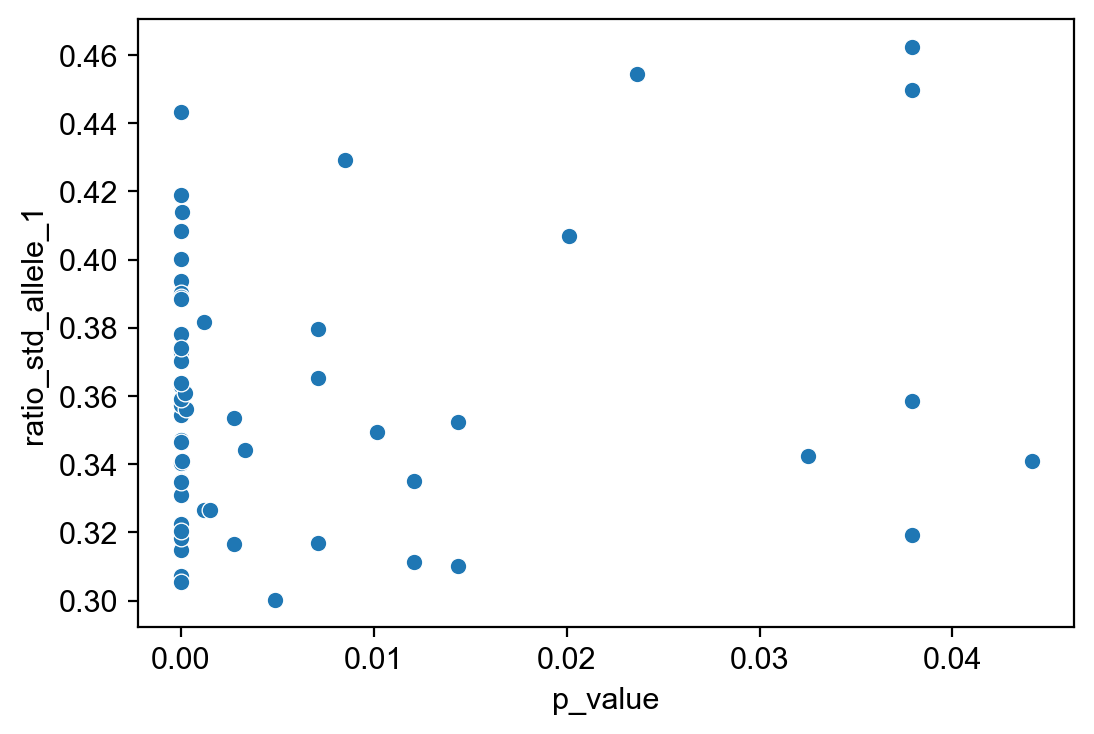

In [9]:
test.sns_scatter(x="p_value", y="ratio_std_allele_1", data=adata.var)

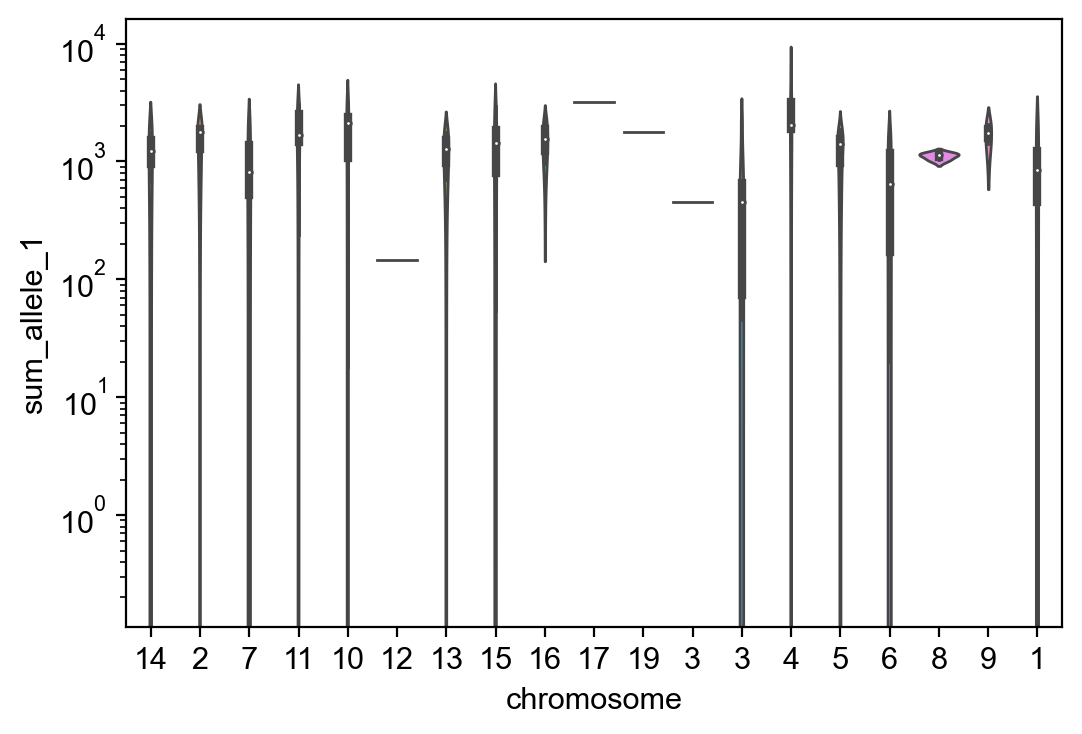

In [10]:
sns.violinplot(data=adata.var, x='chromosome', y='sum_allele_1', linewidth=1)  
plt.yscale('log')

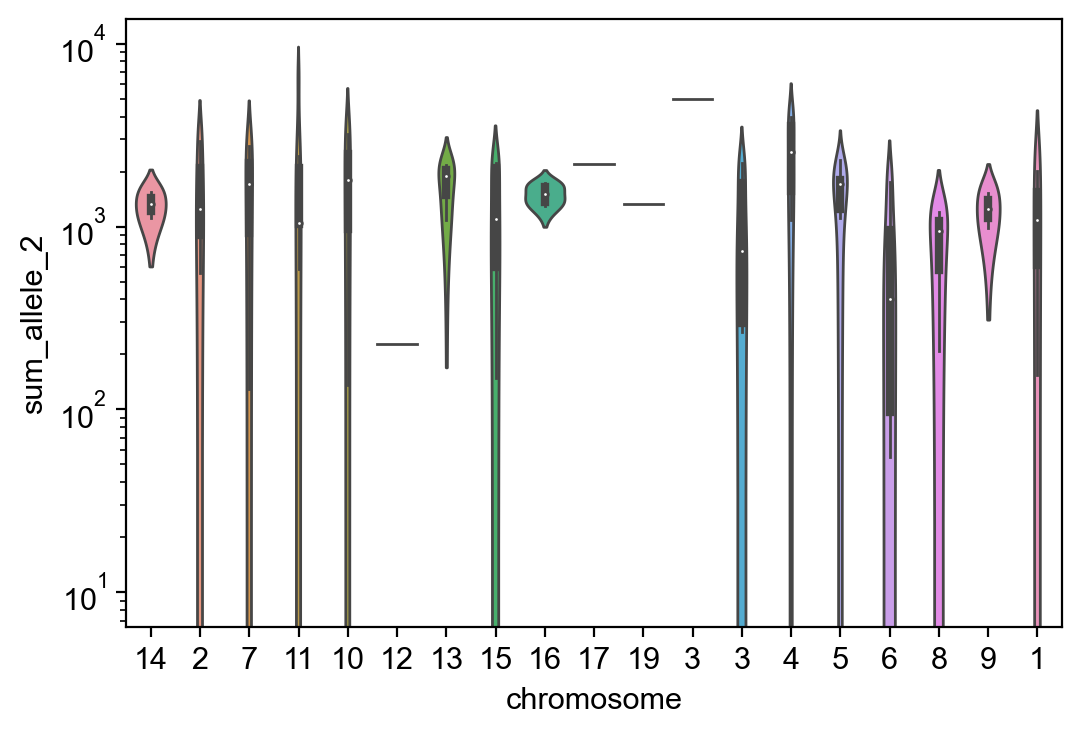

In [11]:
sns.violinplot(data=adata.var, x='chromosome', y='sum_allele_2', linewidth=1)  
plt.yscale('log')

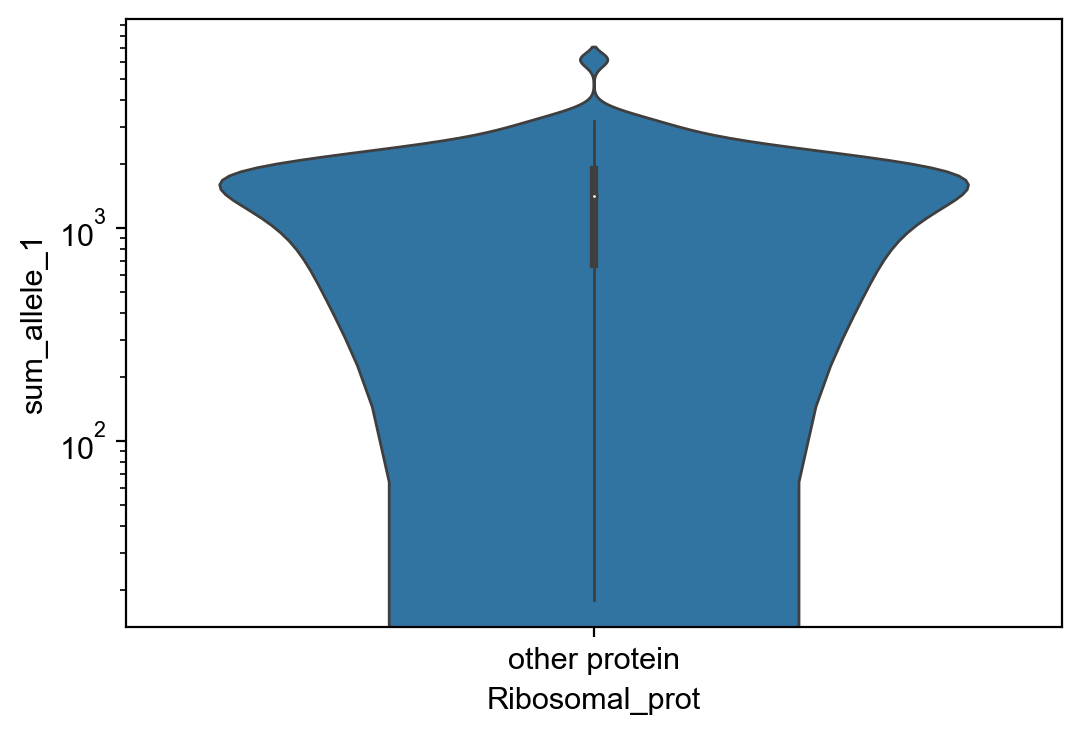

In [12]:
sns.violinplot(data=adata.var, x='Ribosomal_prot', y='sum_allele_1', linewidth=1)  
plt.yscale('log')

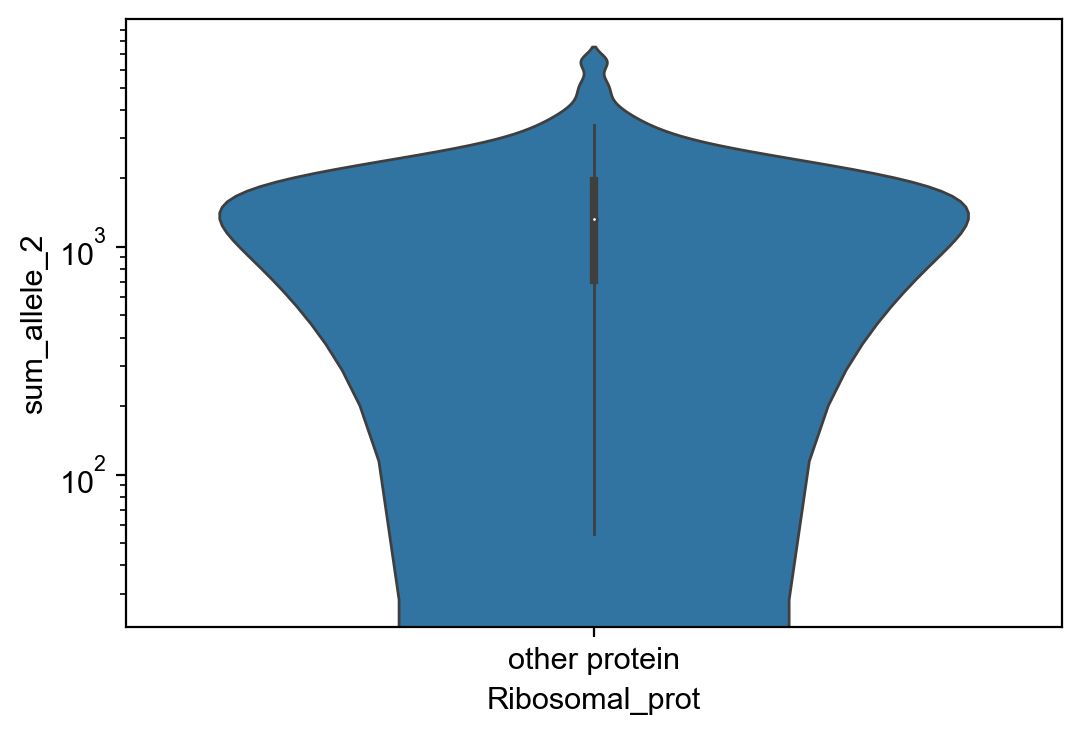

In [13]:
sns.violinplot(data=adata.var, x='Ribosomal_prot', y='sum_allele_2', linewidth=1)  
plt.yscale('log')

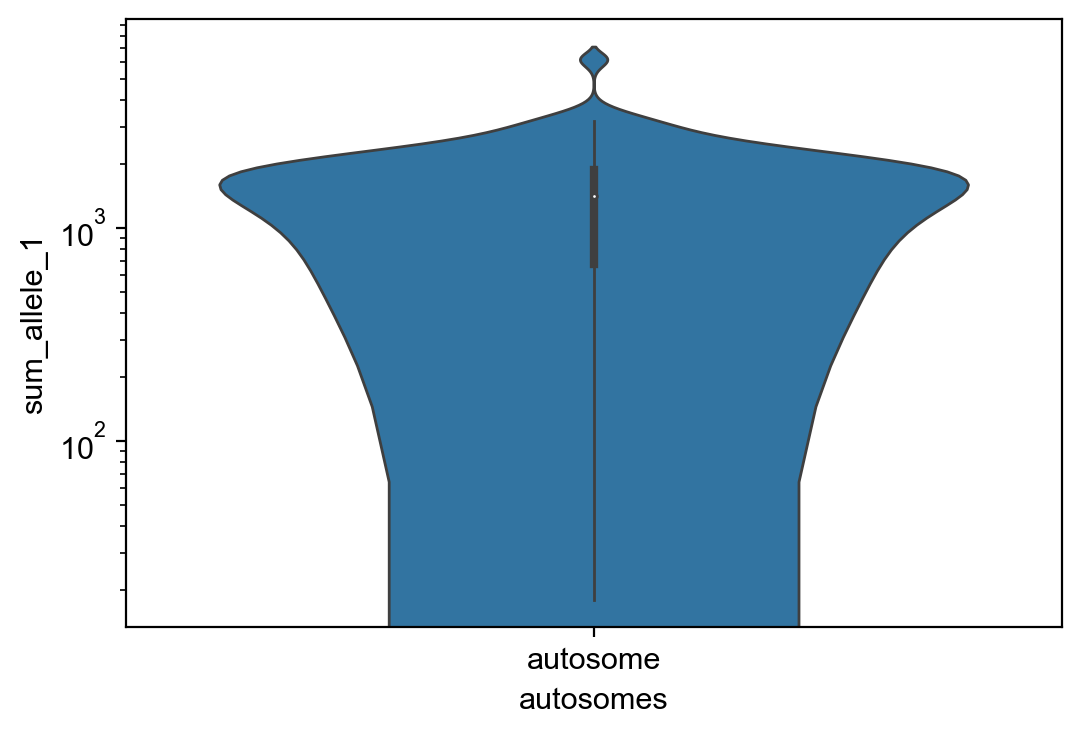

In [14]:
sns.violinplot(data=adata.var, x='autosomes', y='sum_allele_1', linewidth=1)  
plt.yscale('log')

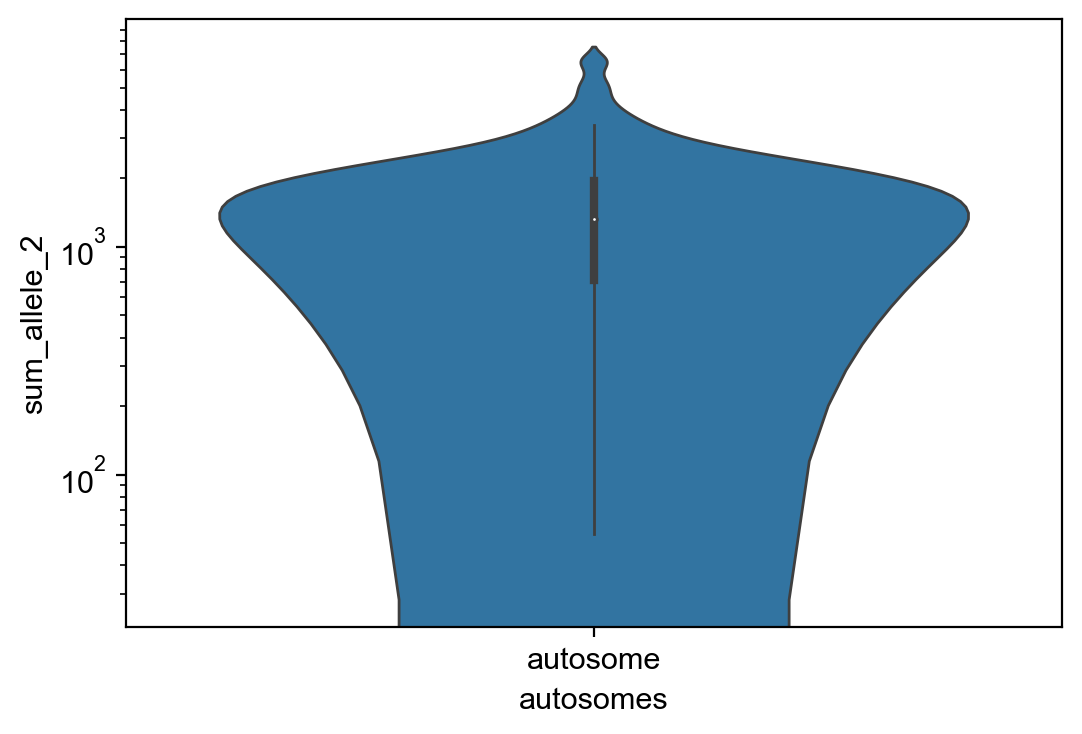

In [15]:
sns.violinplot(data=adata.var, x='autosomes', y='sum_allele_2', linewidth=1)  
plt.yscale('log')

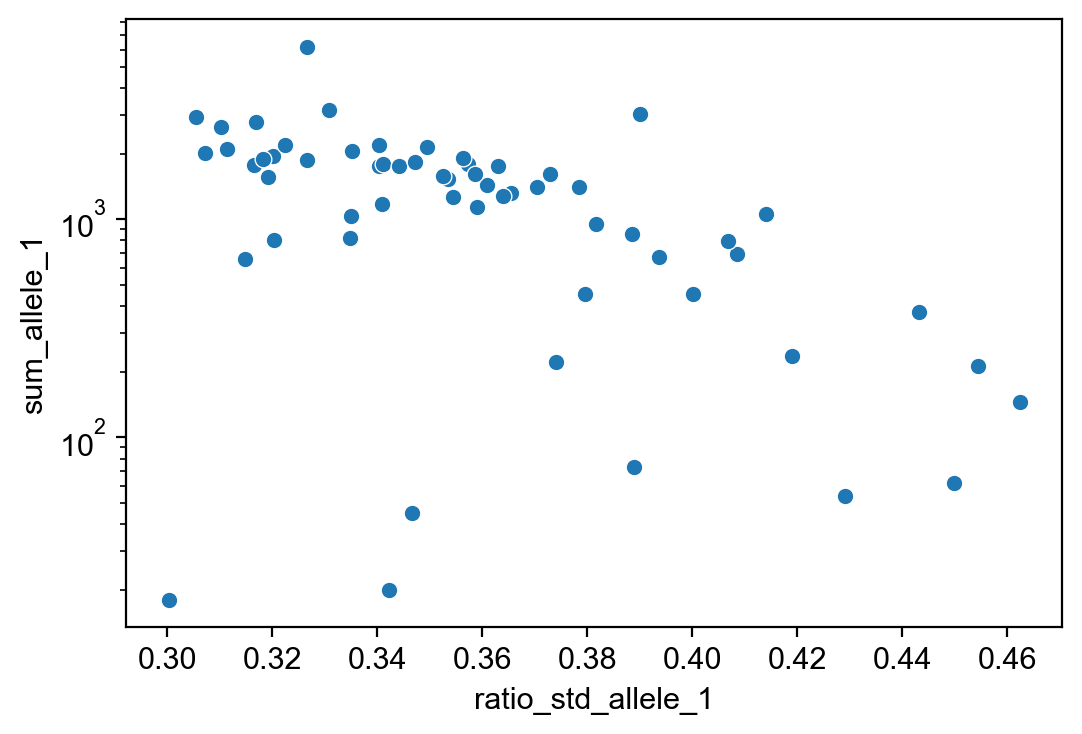

In [16]:
test.sns_scatter(x="ratio_std_allele_1", y="sum_allele_1", data=adata.var)
plt.yscale('log')

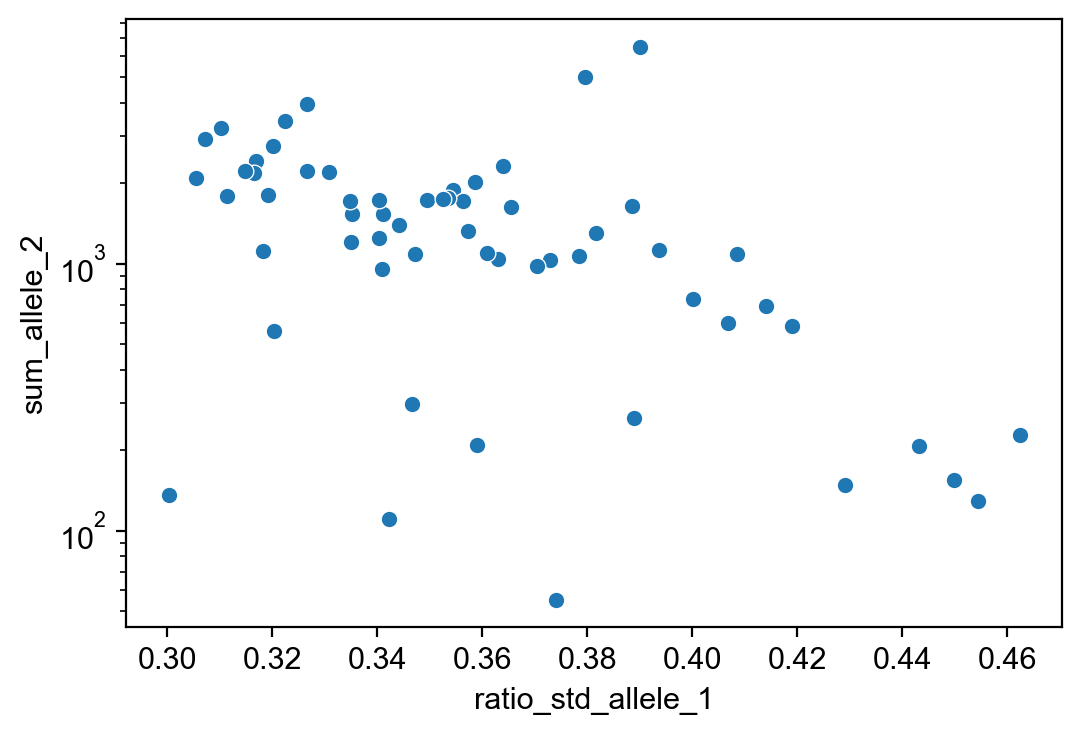

In [17]:
test.sns_scatter(x="ratio_std_allele_1", y="sum_allele_2", data=adata.var)
plt.yscale('log')

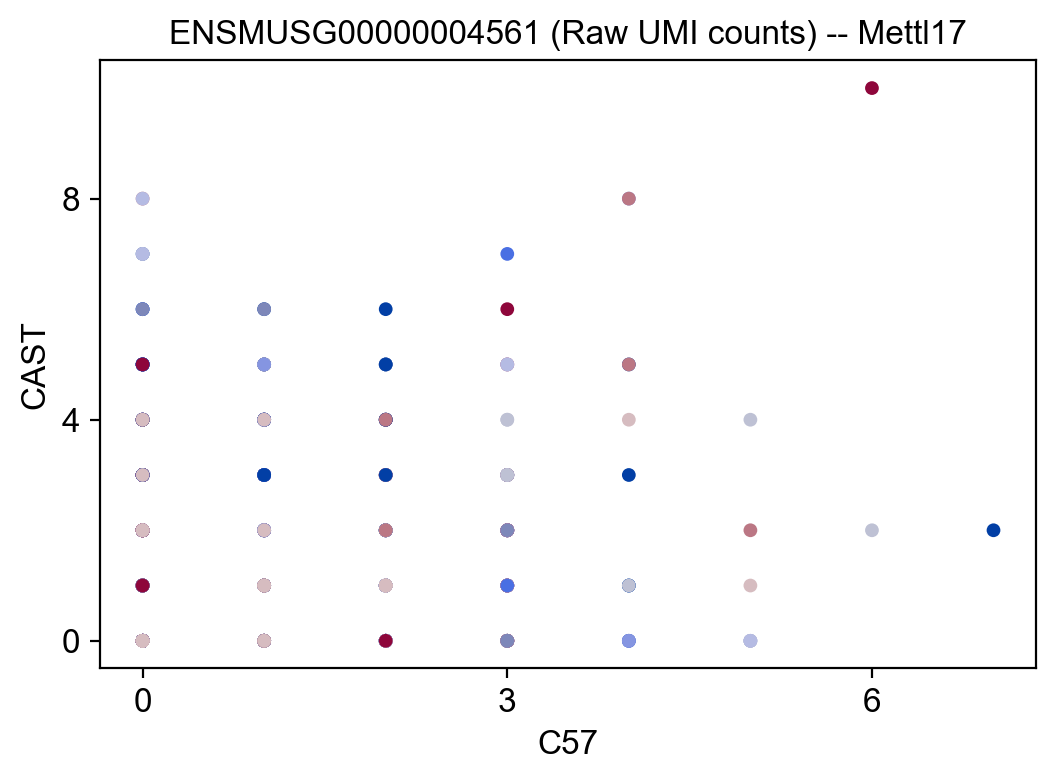

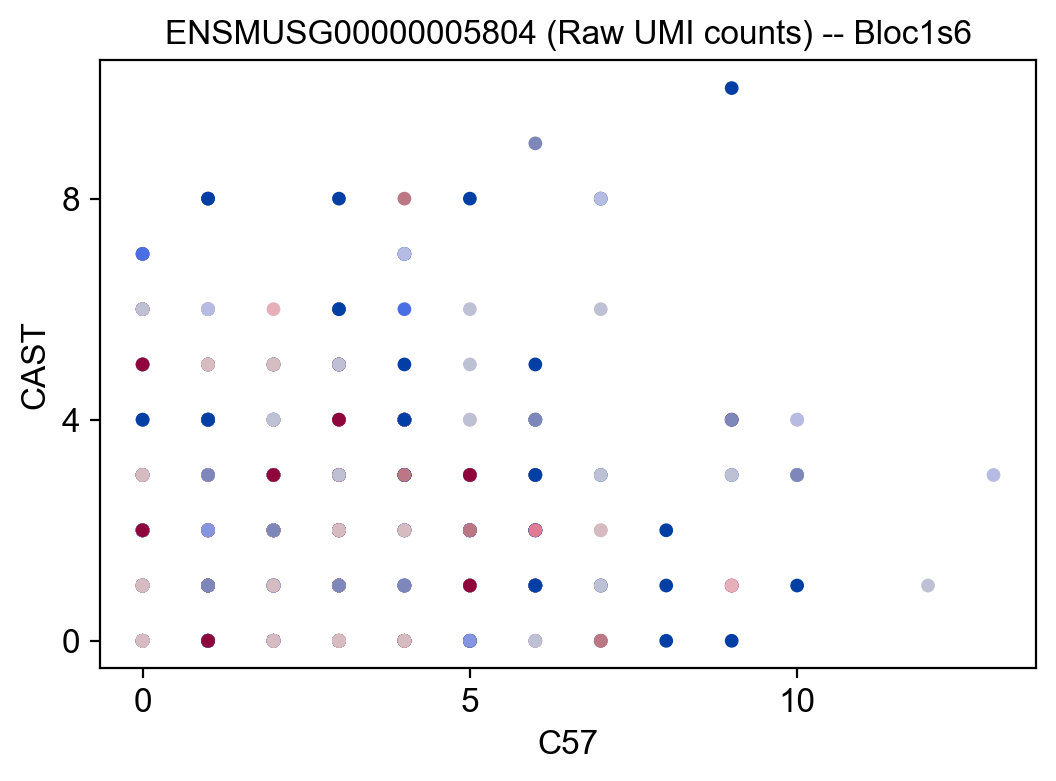

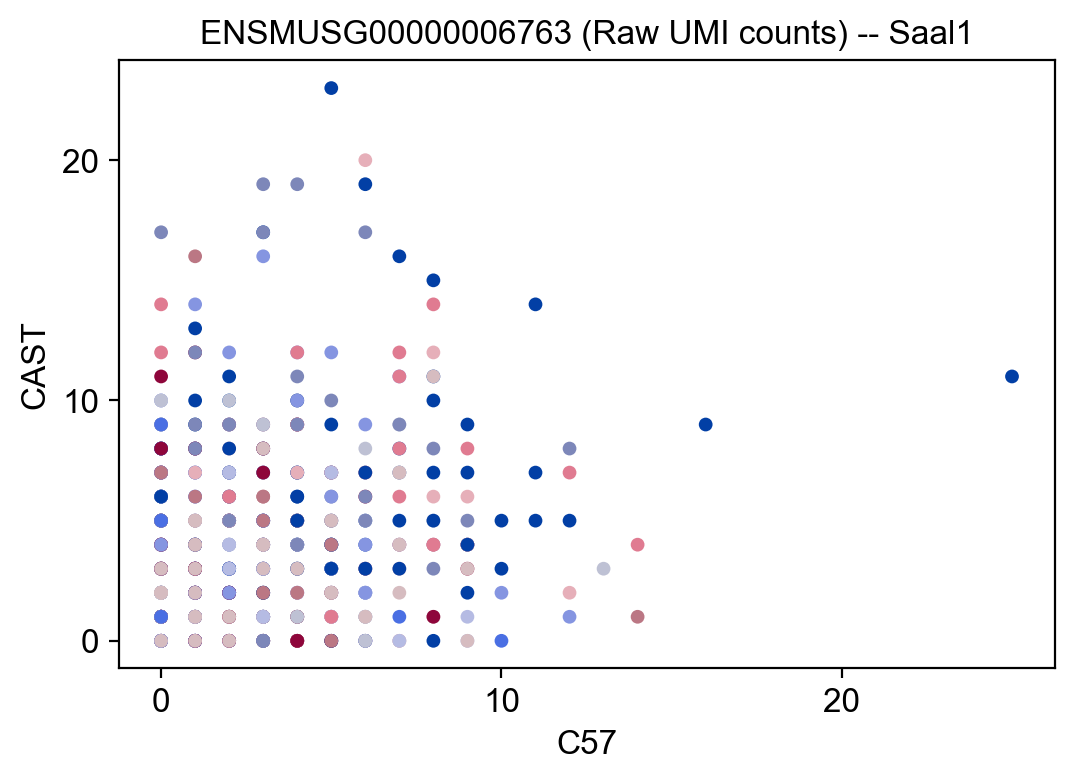

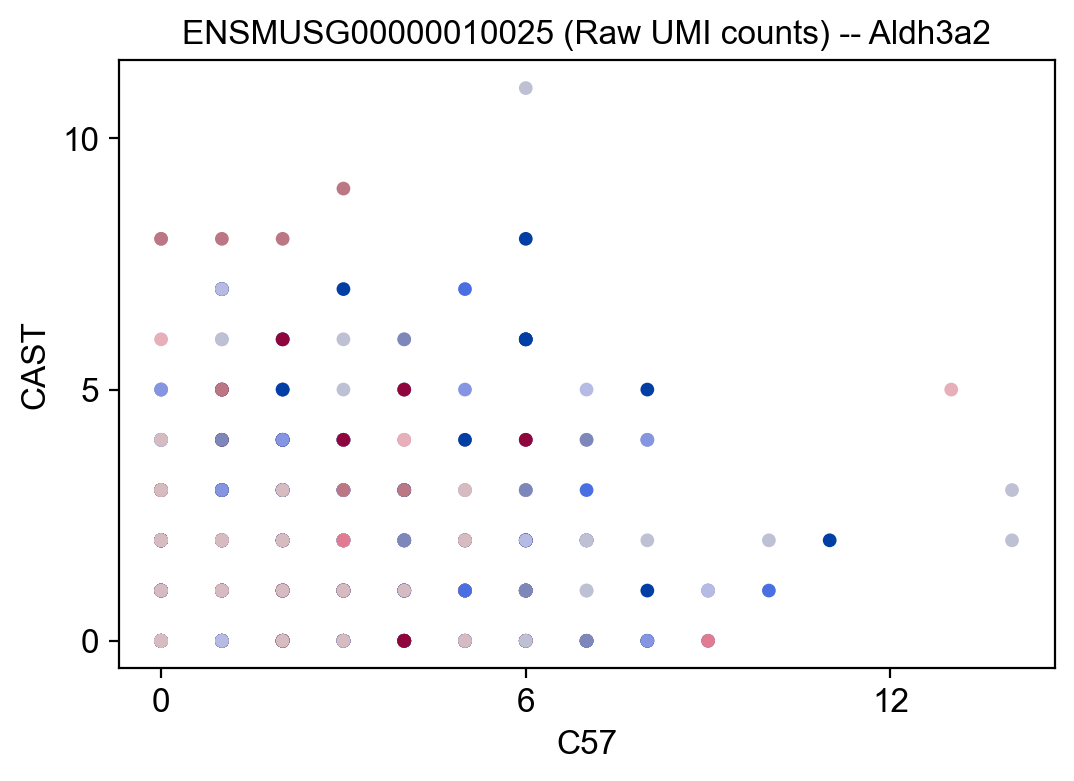

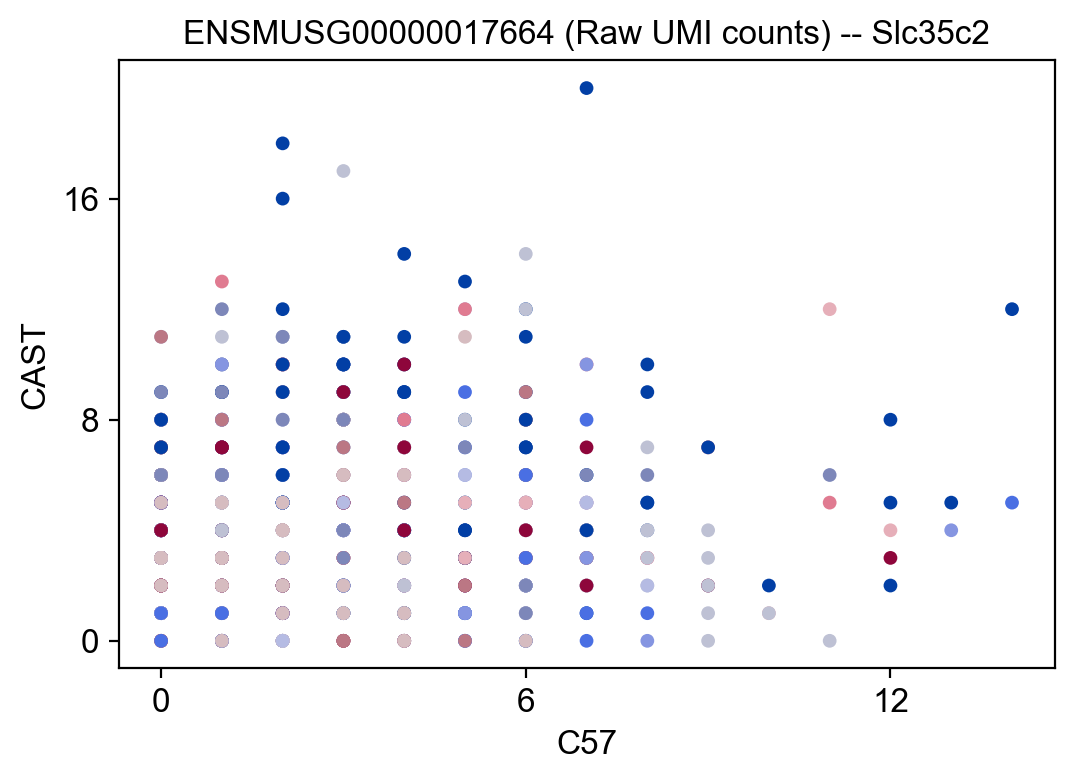

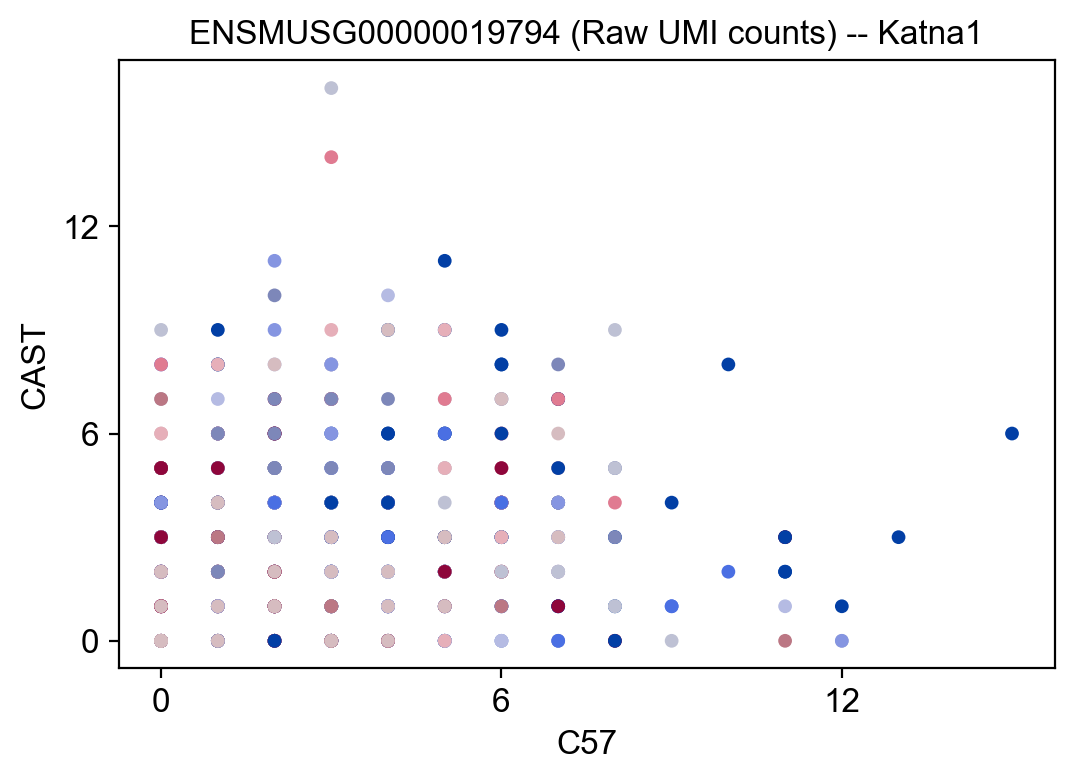

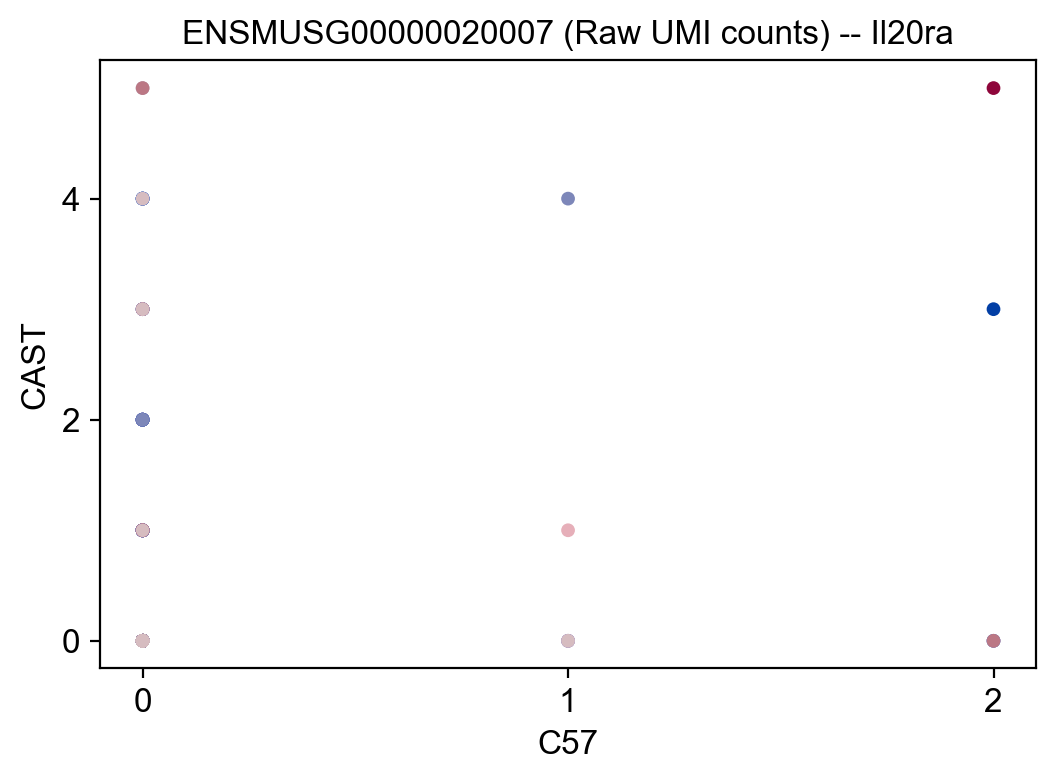

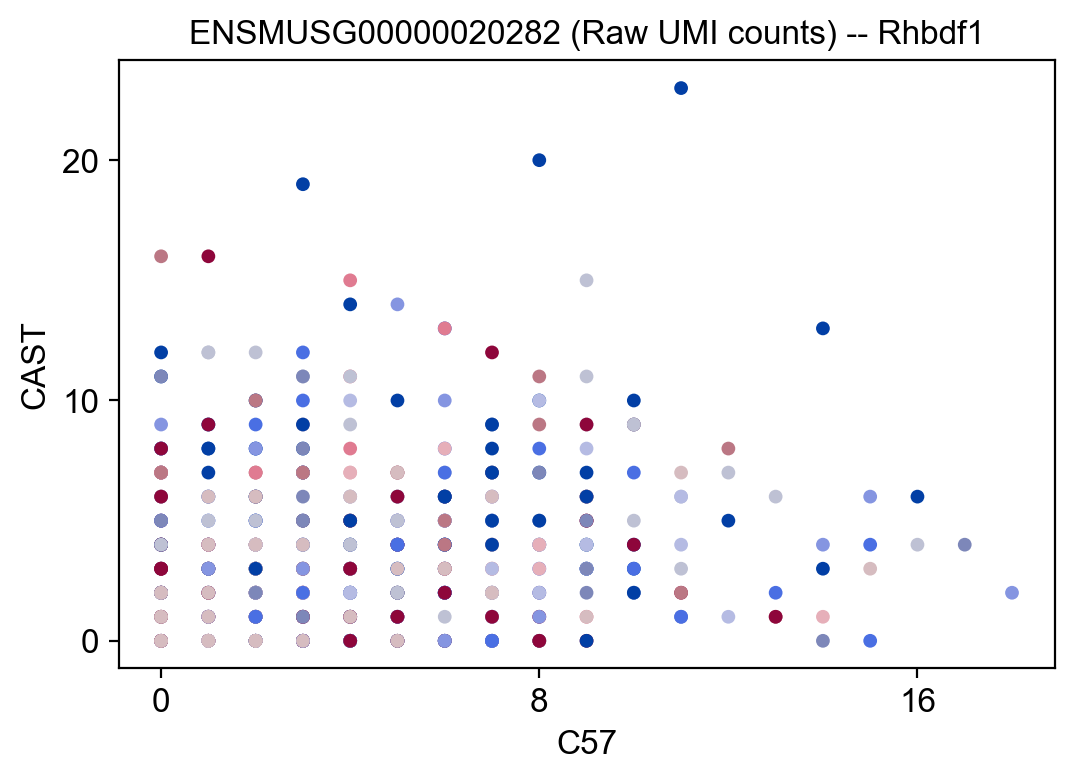

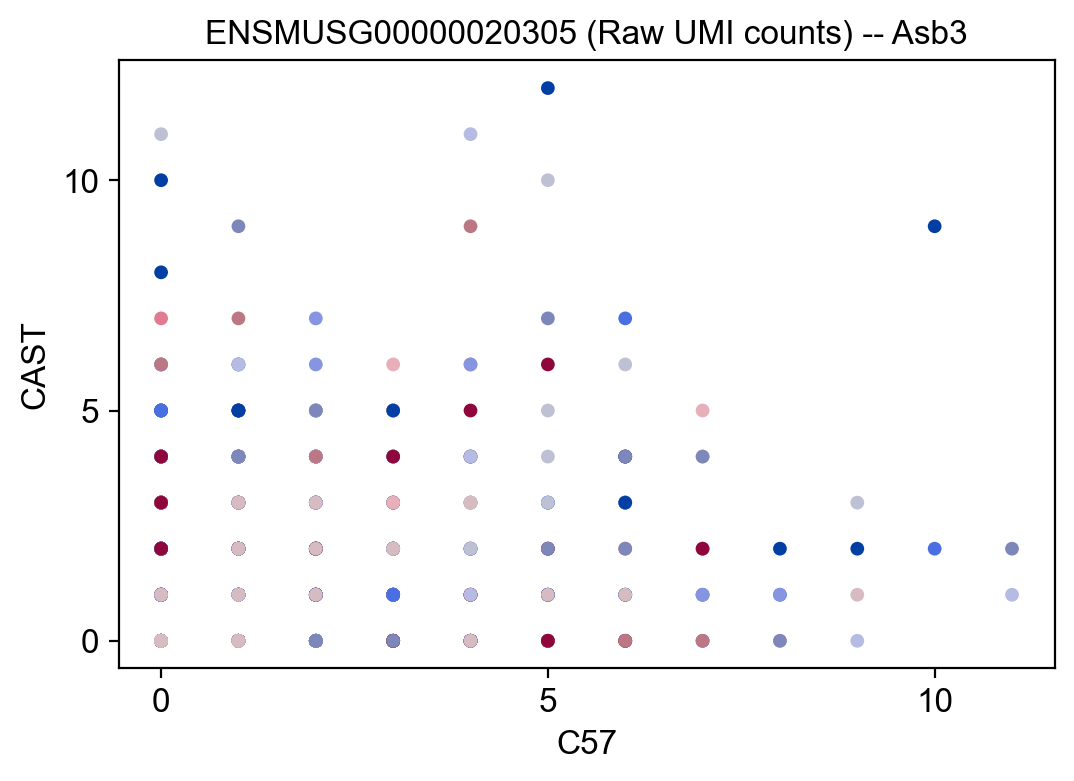

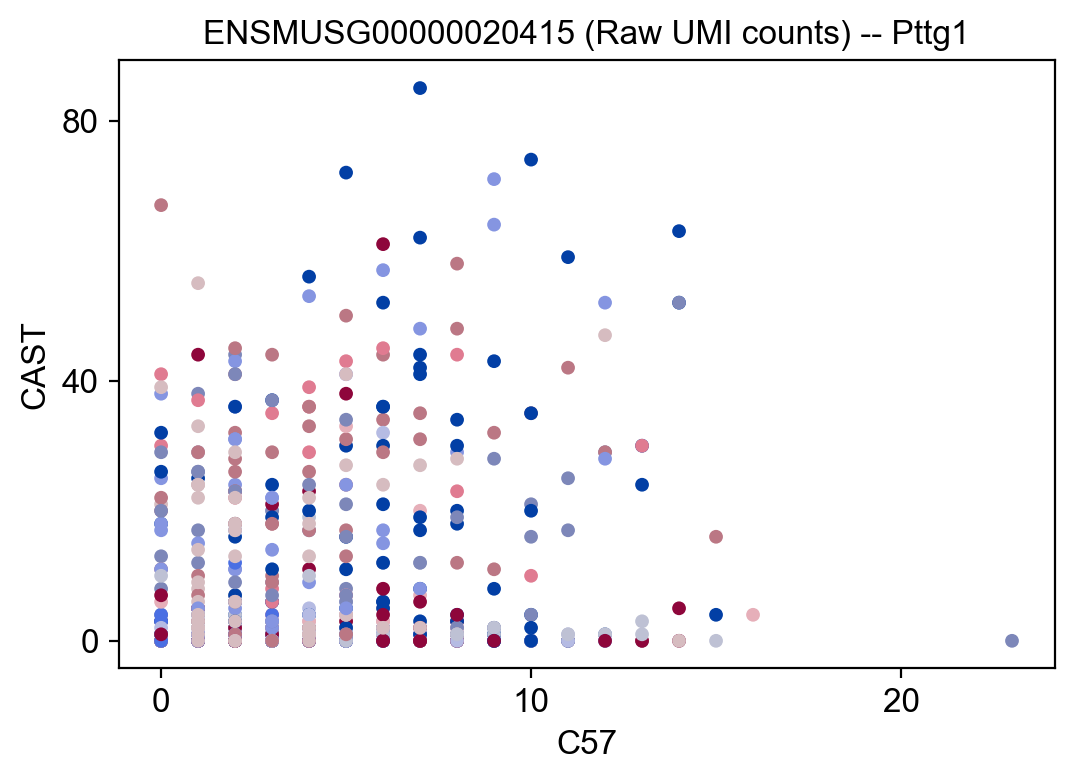

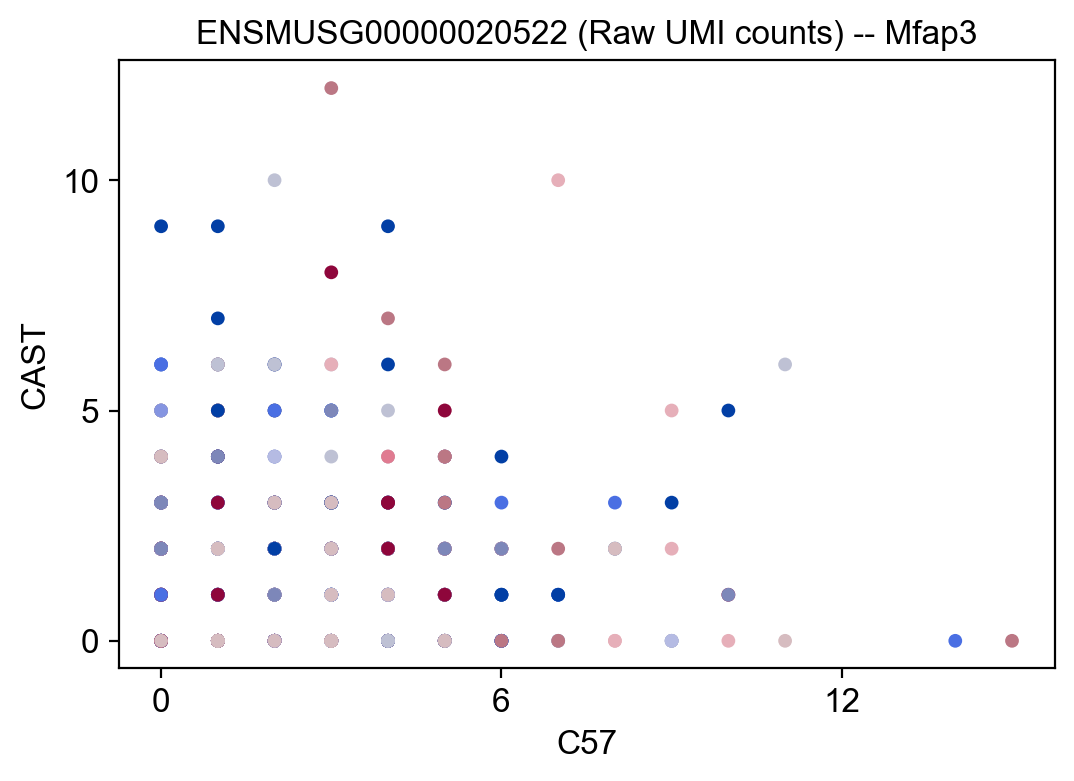

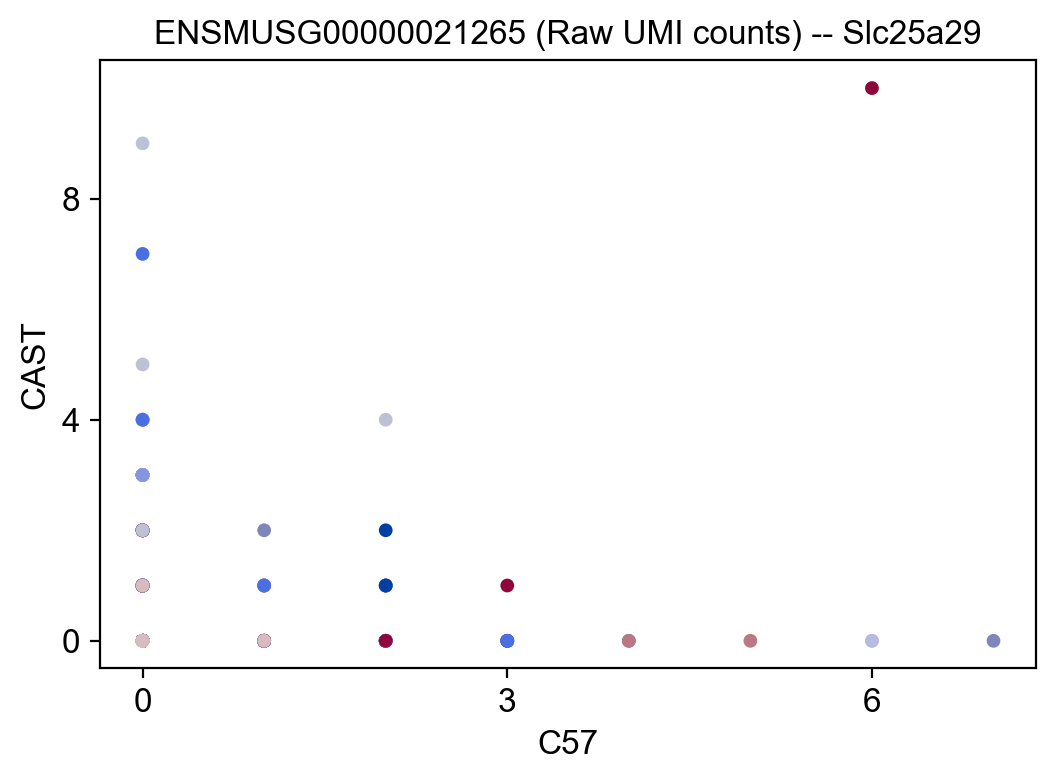

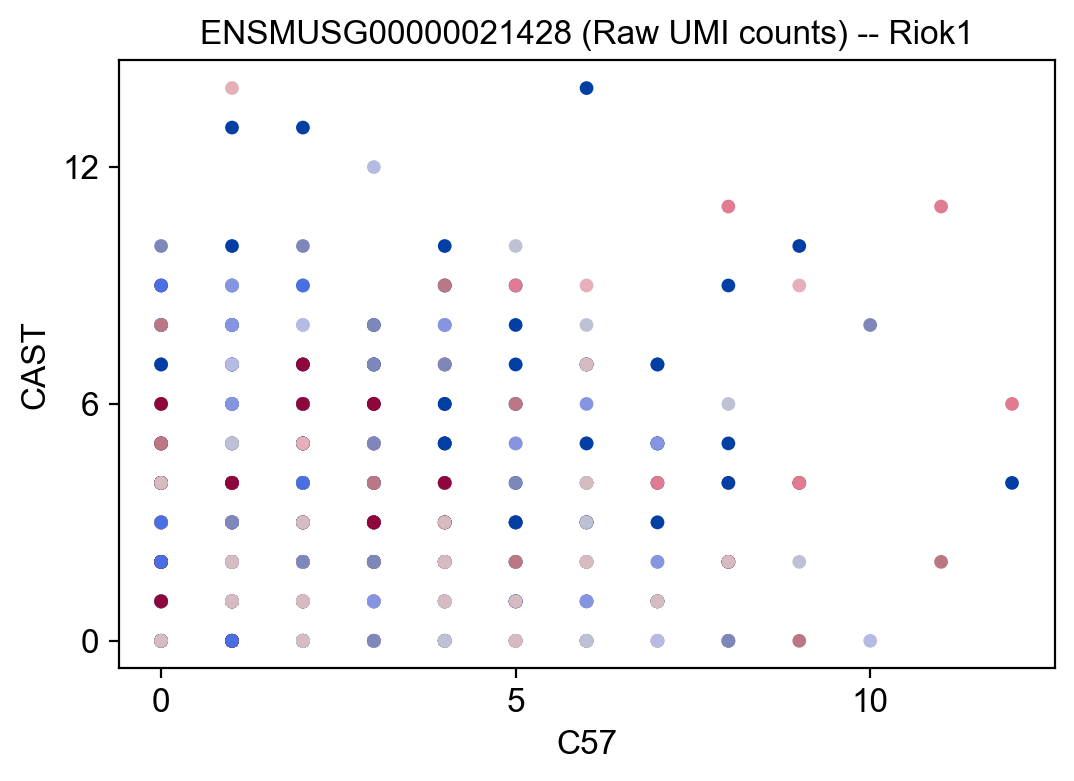

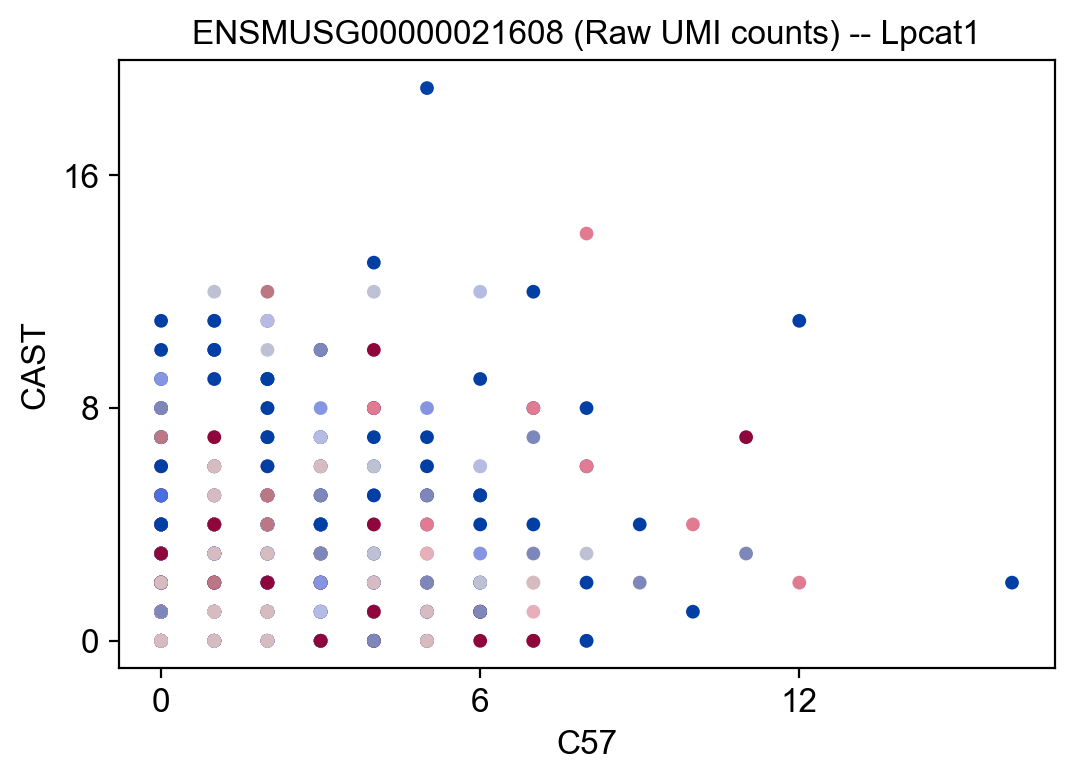

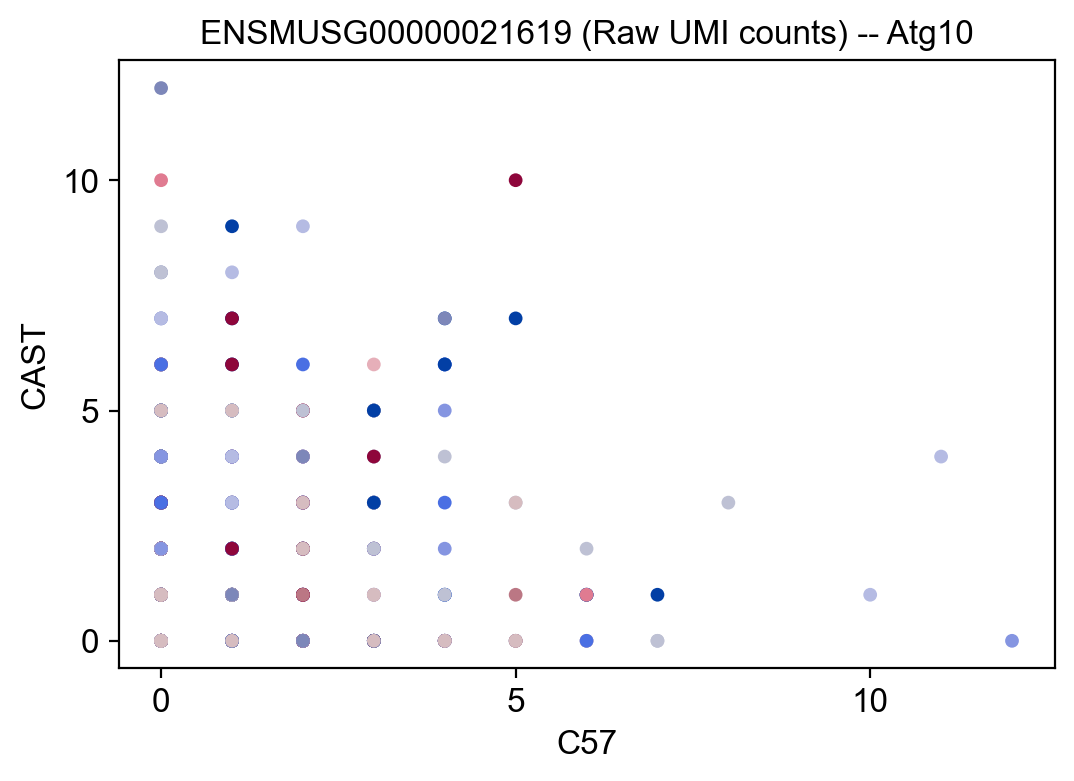

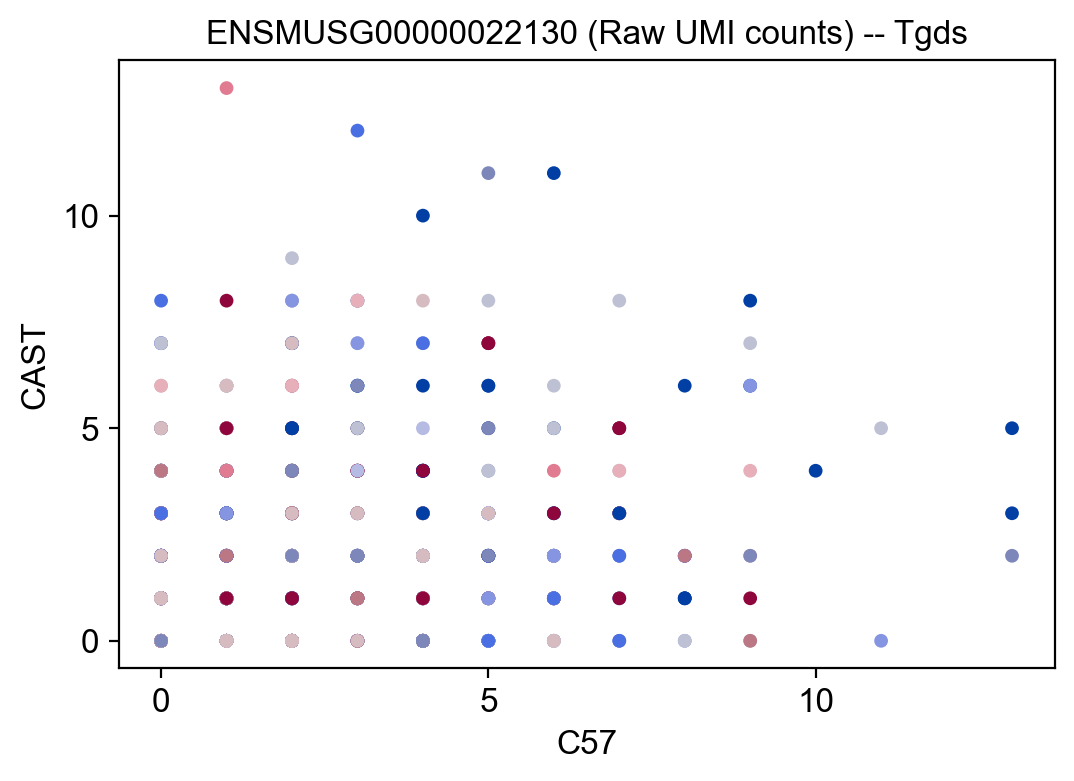

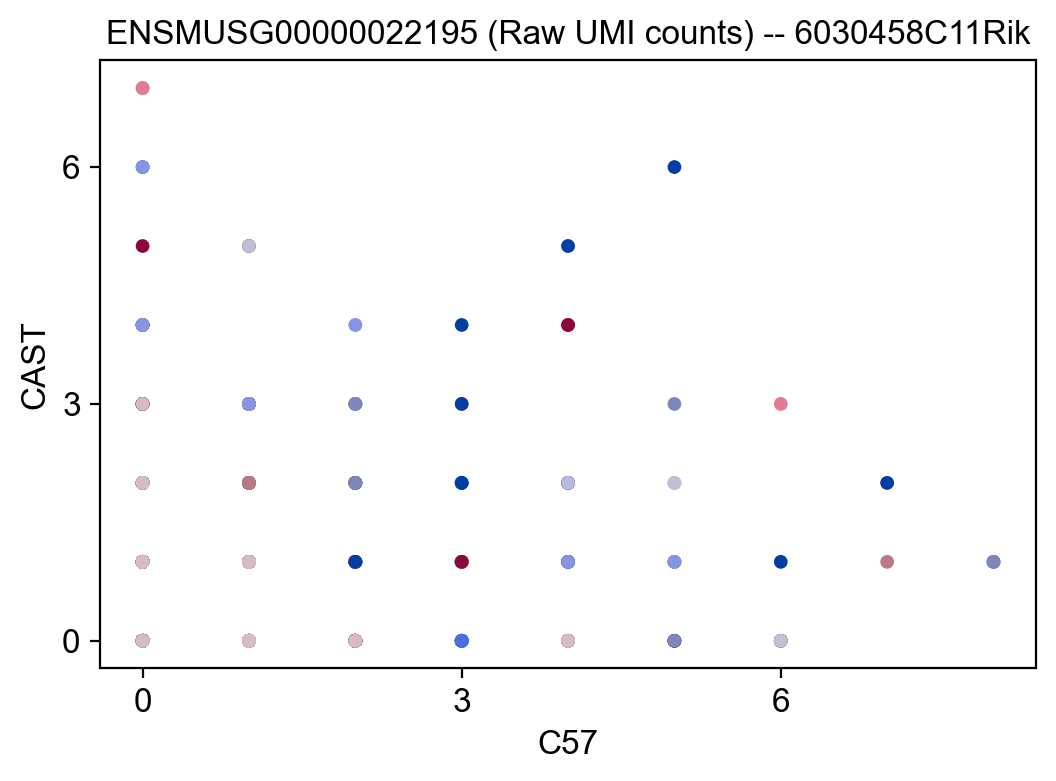

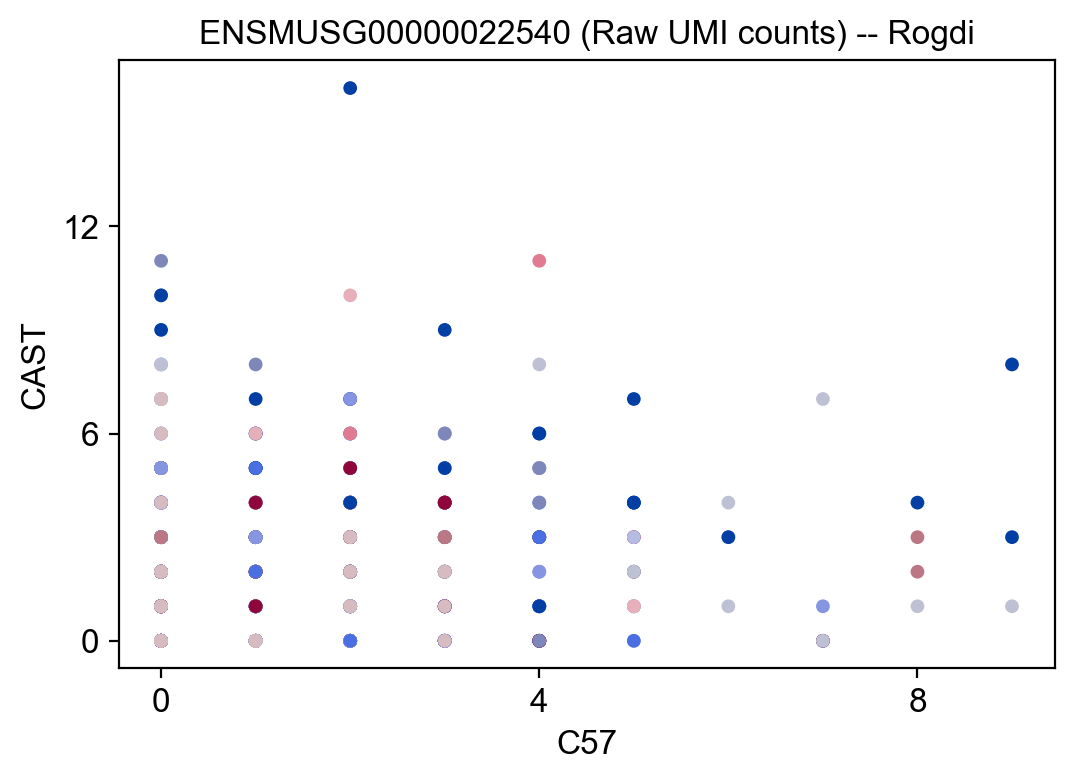

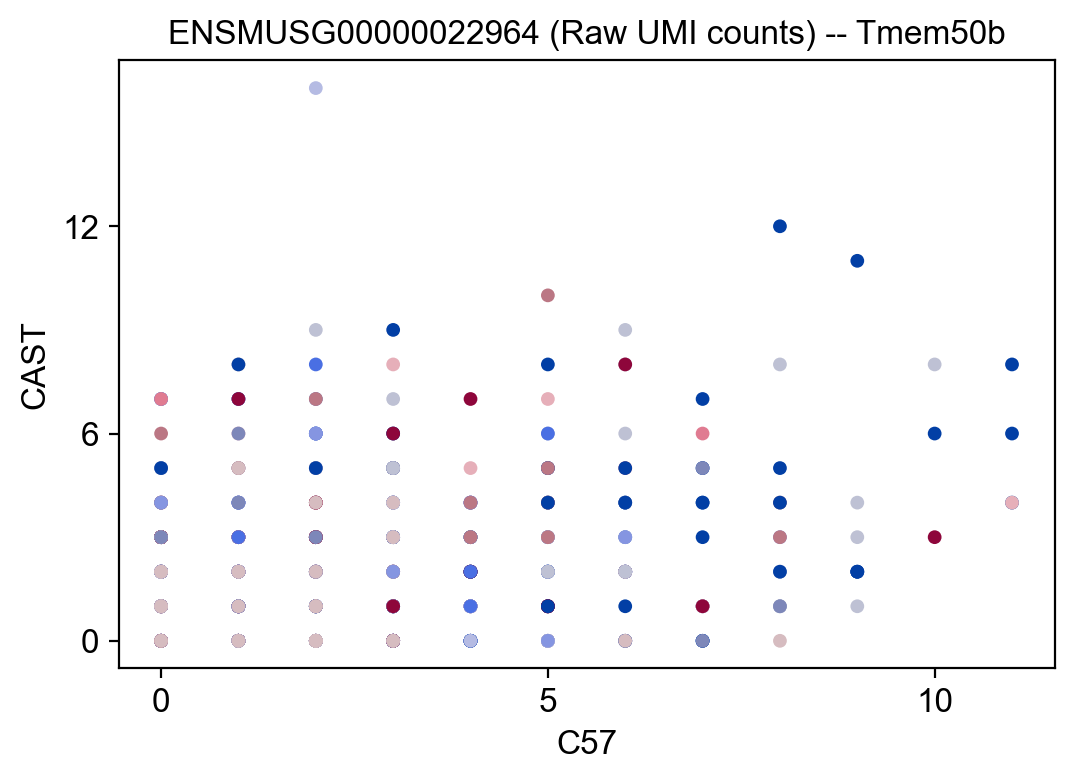

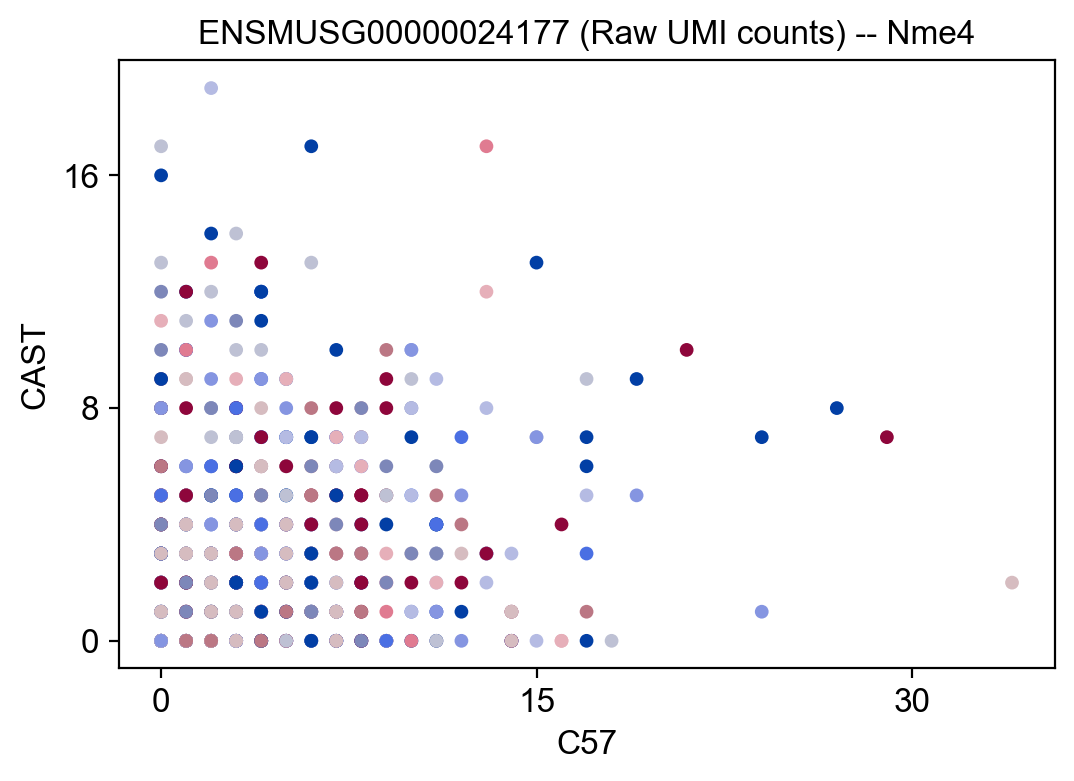

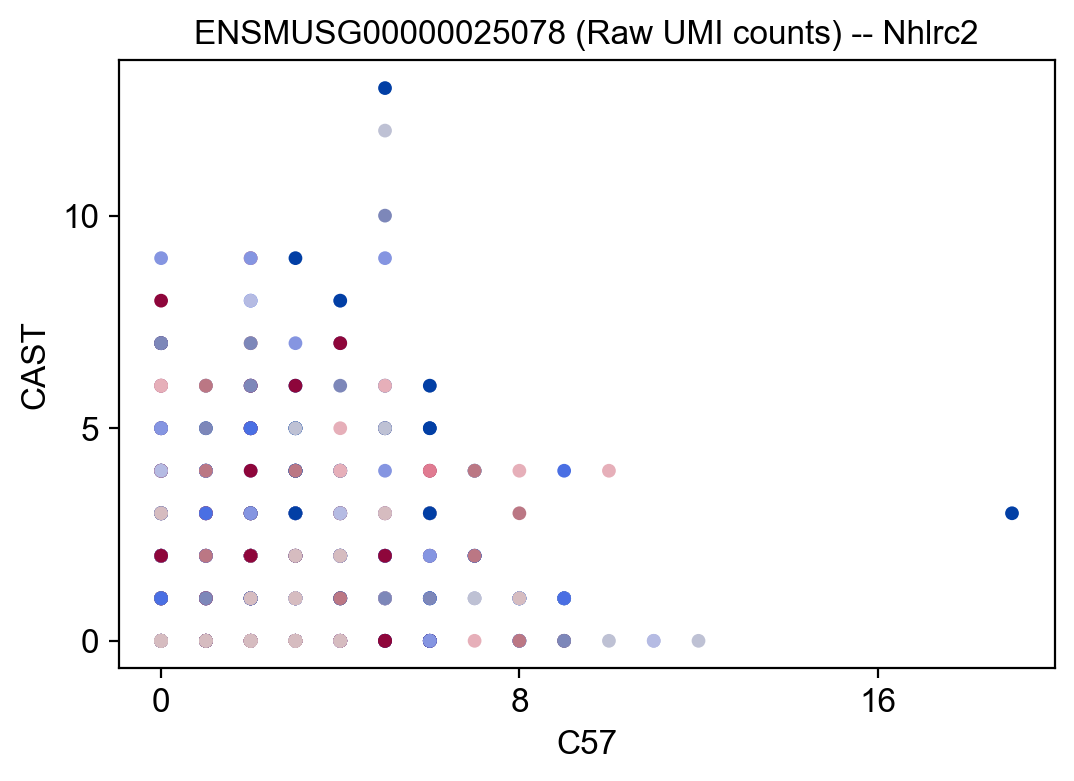

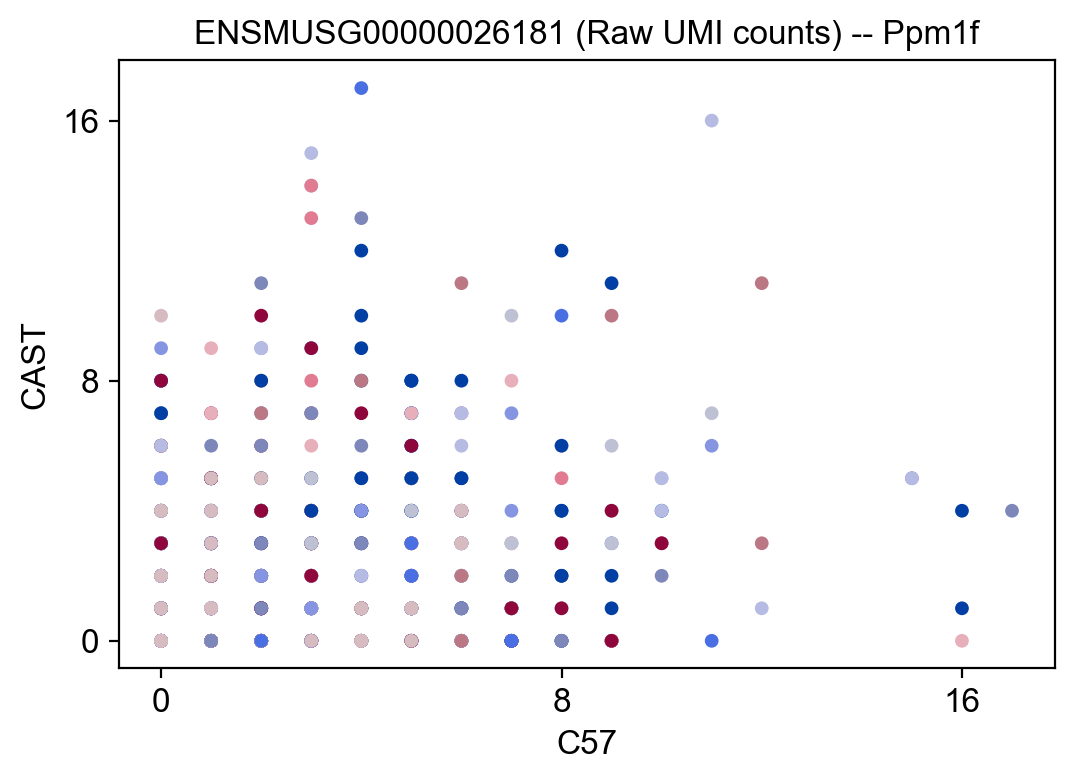

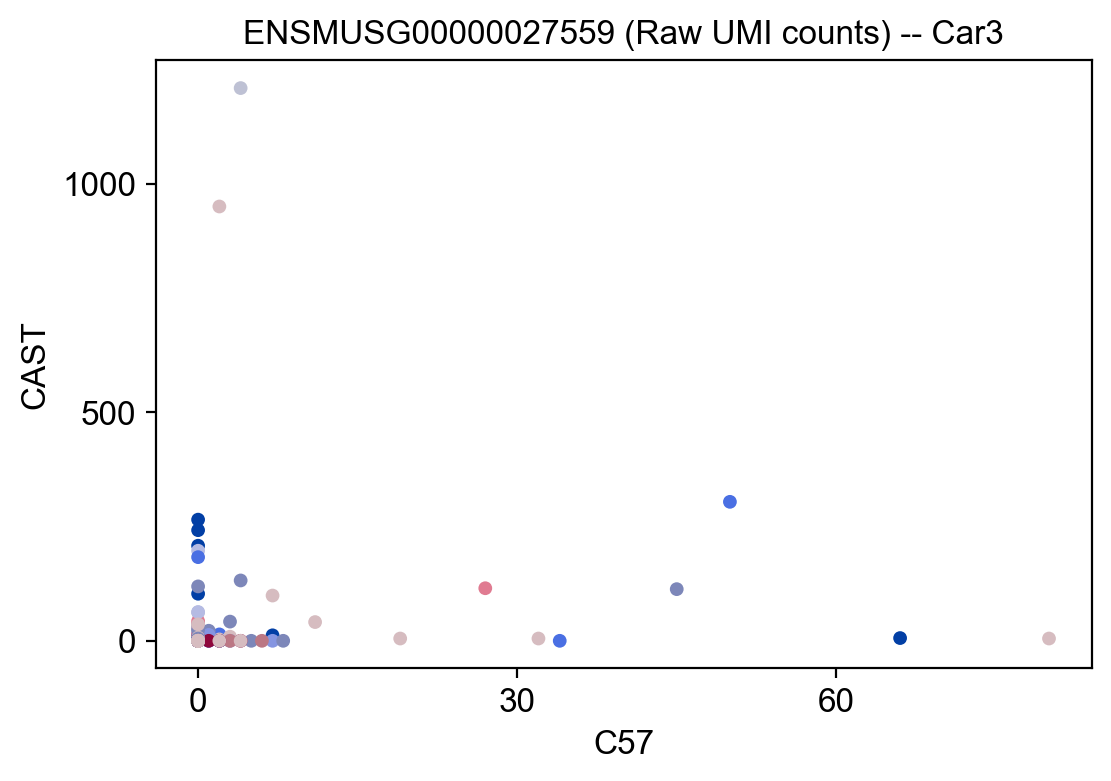

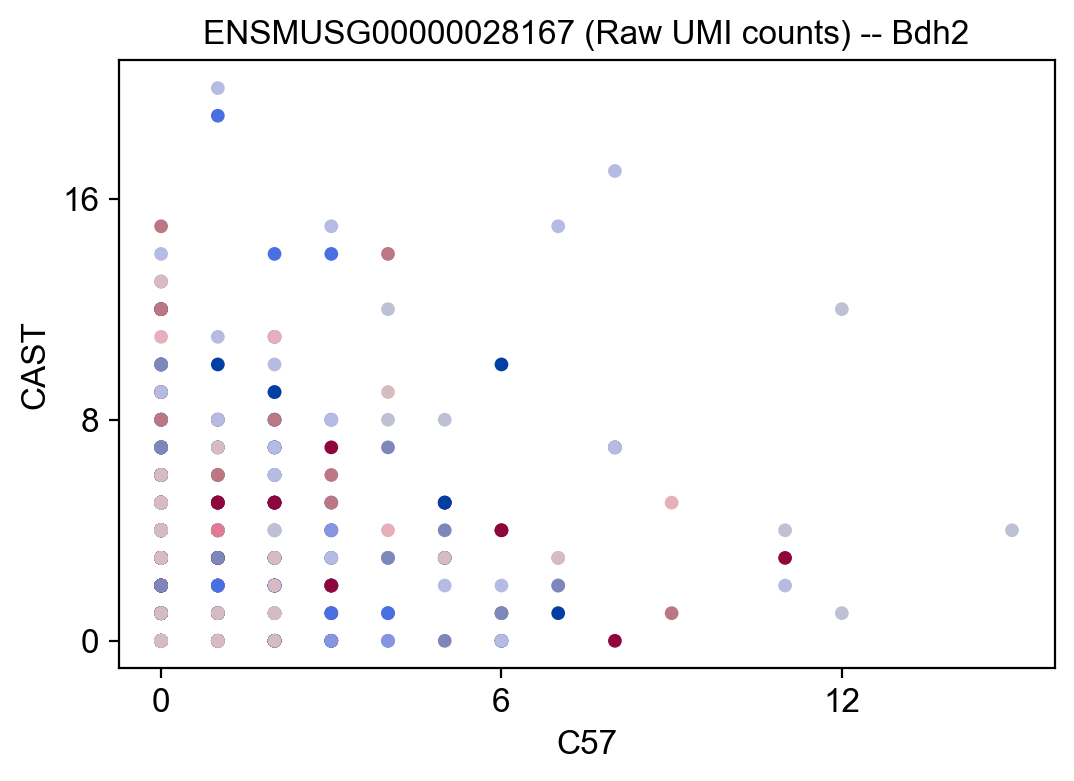

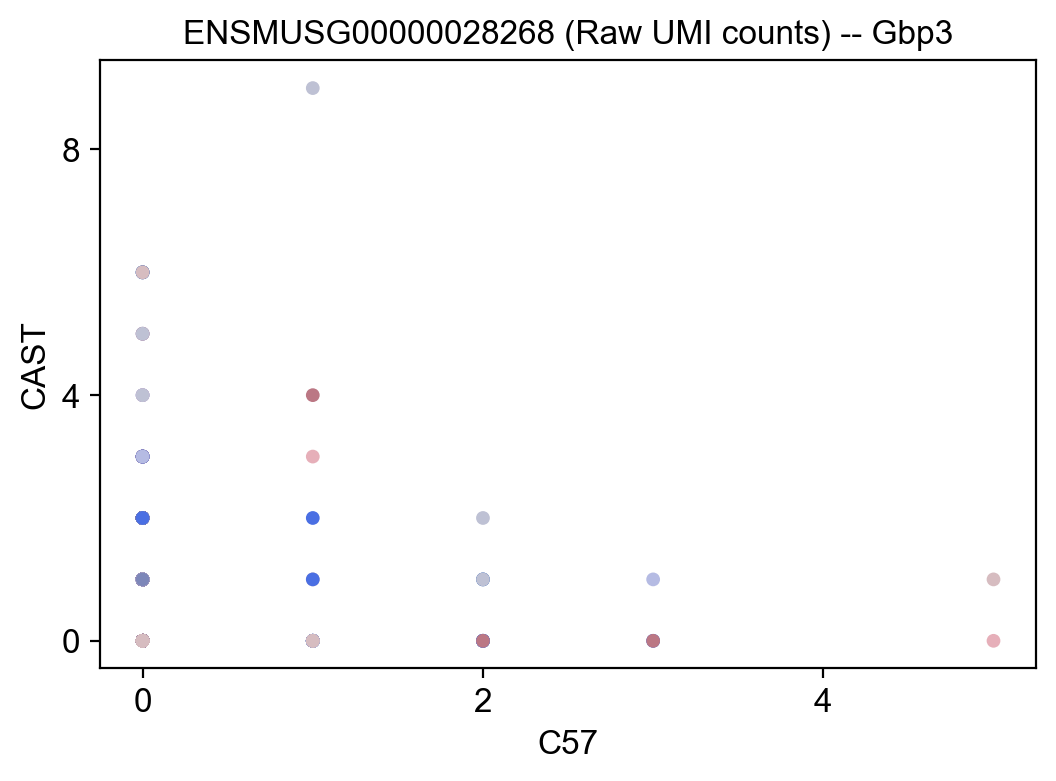

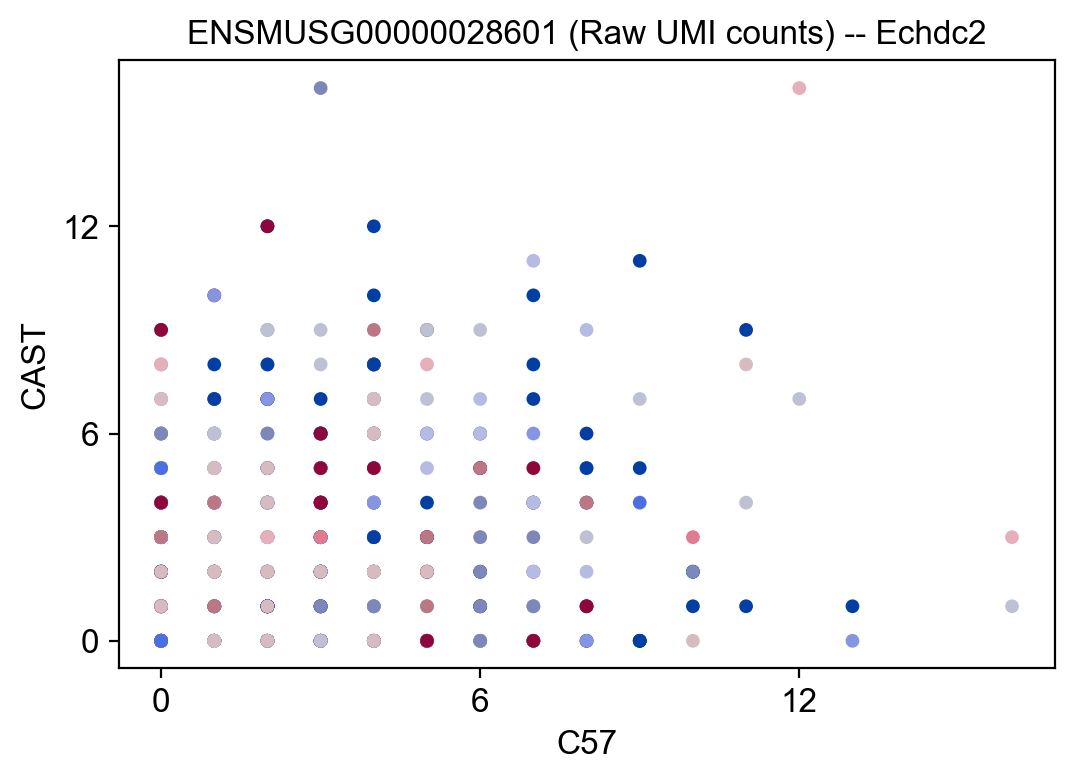

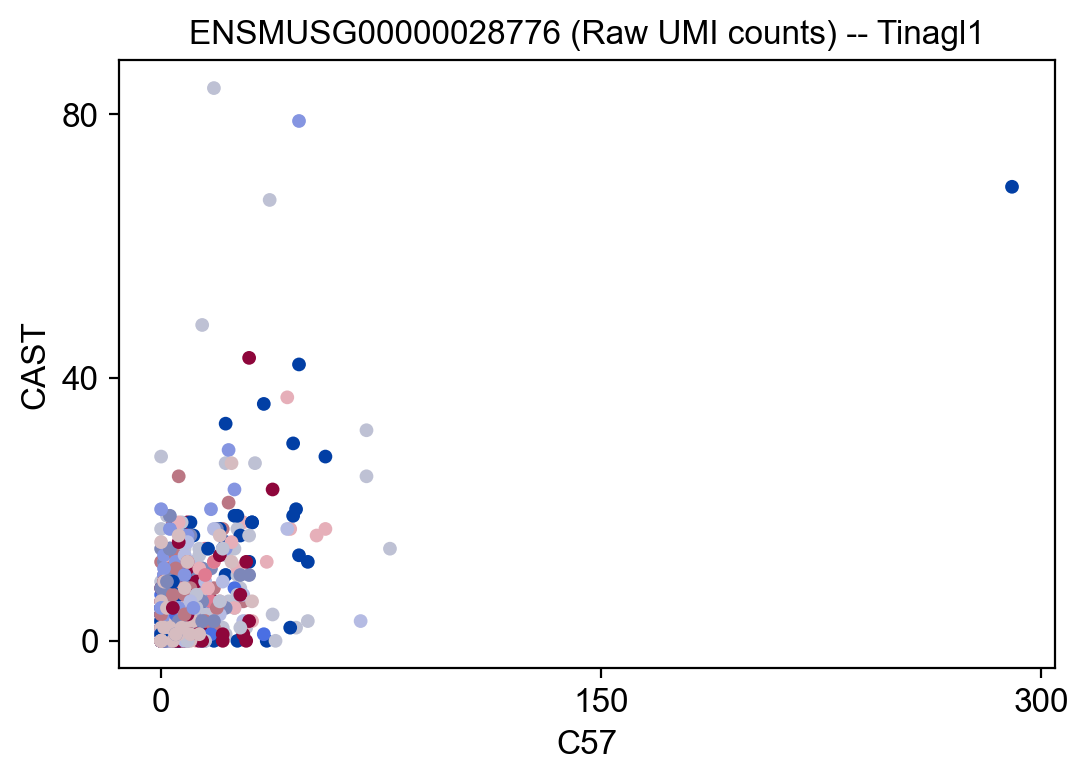

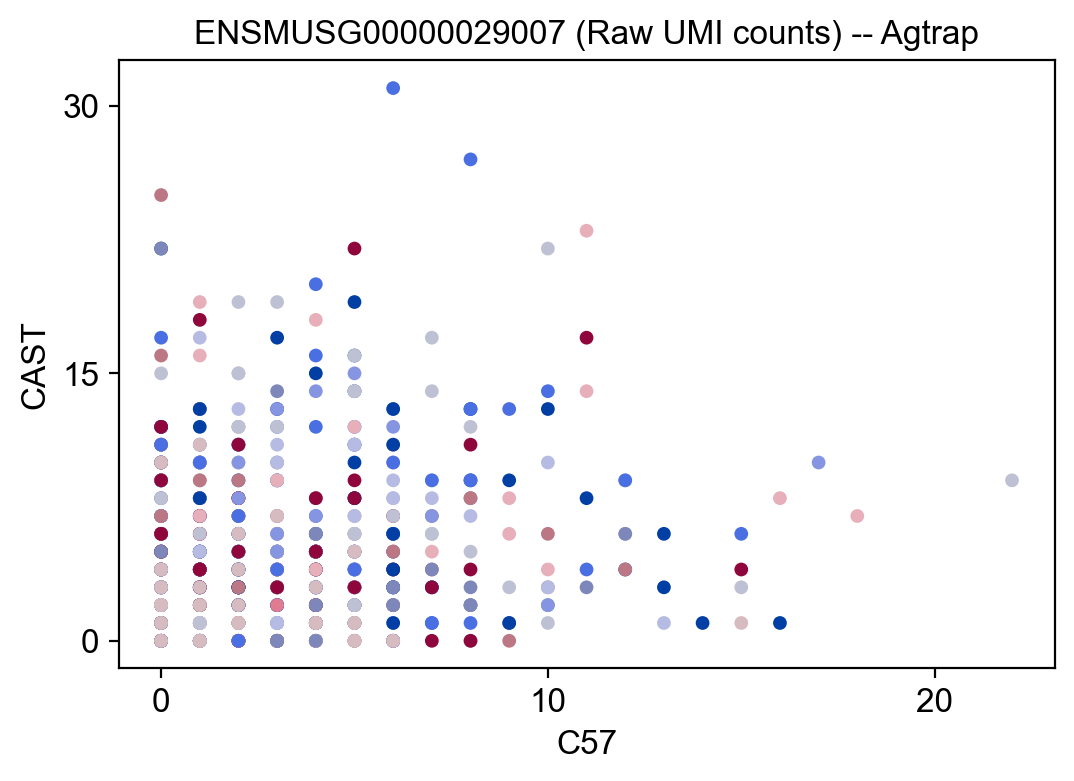

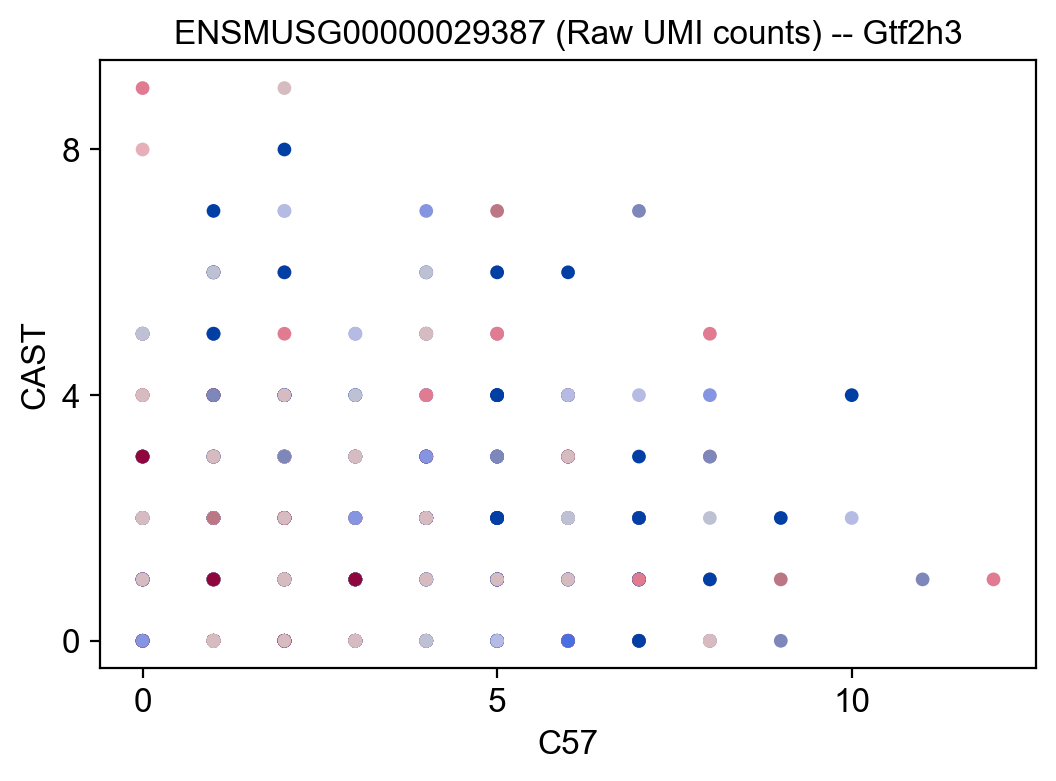

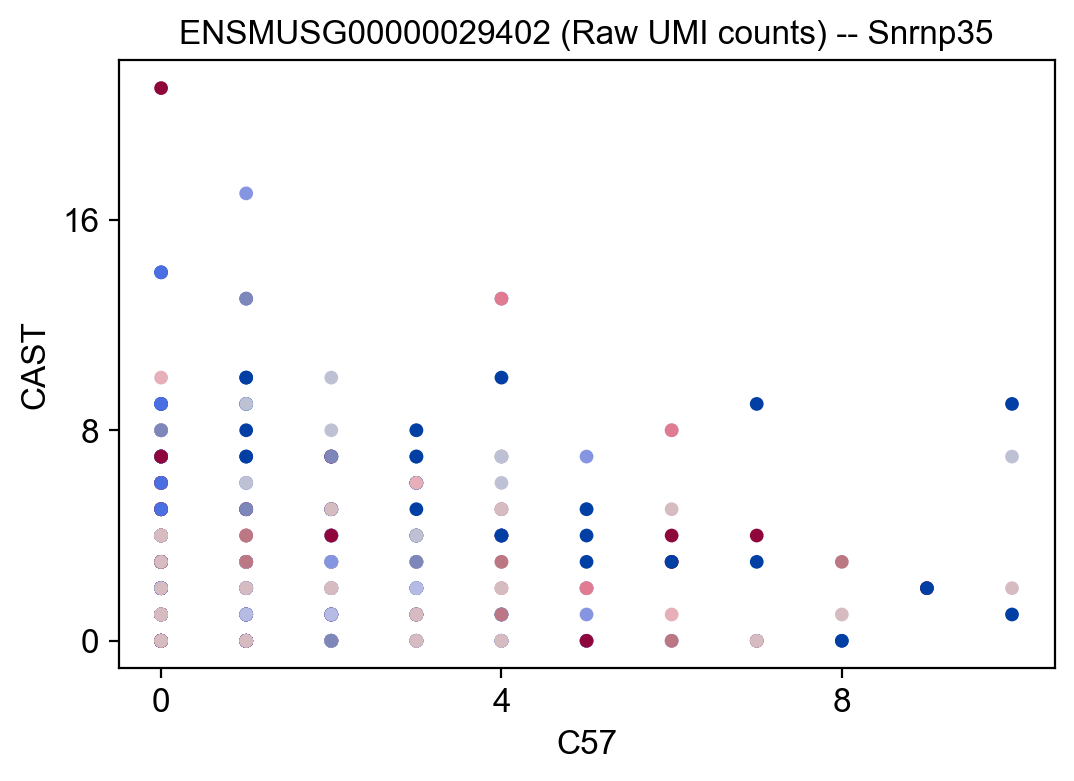

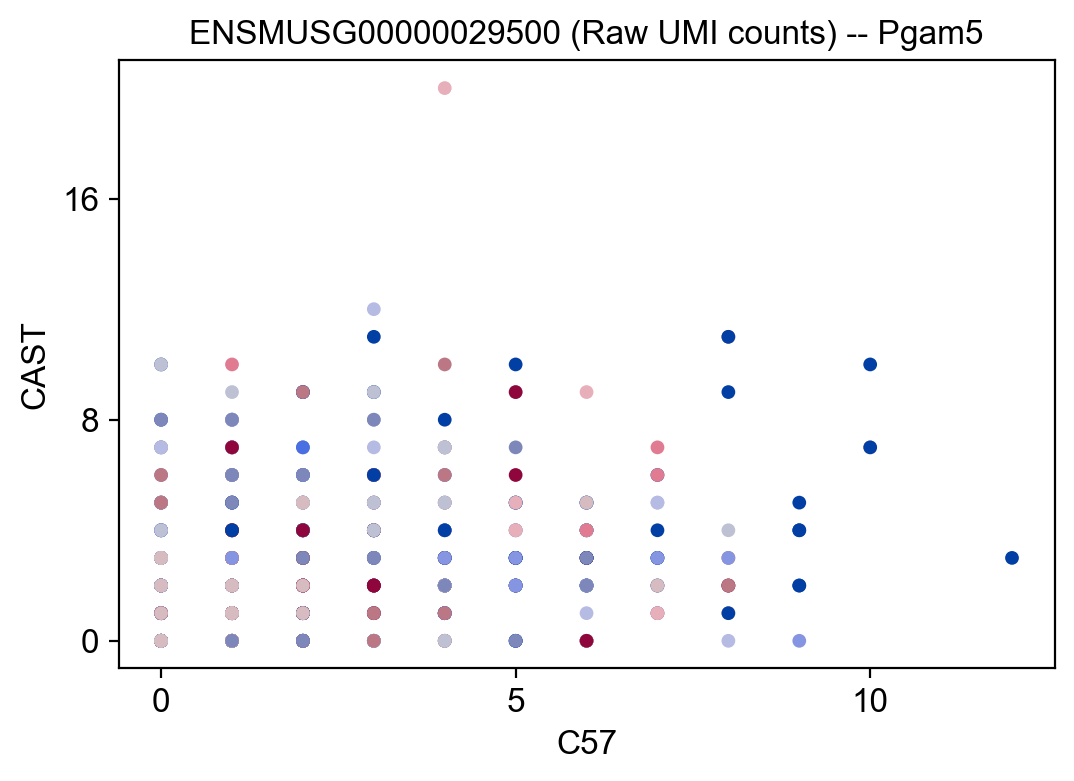

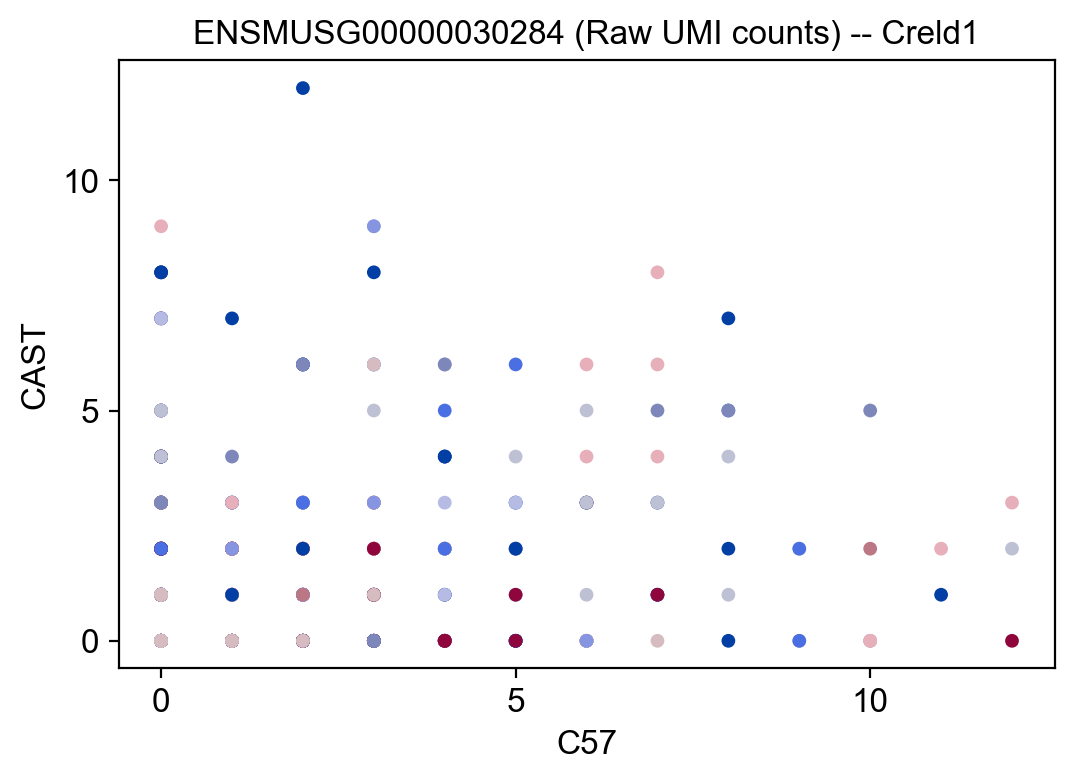

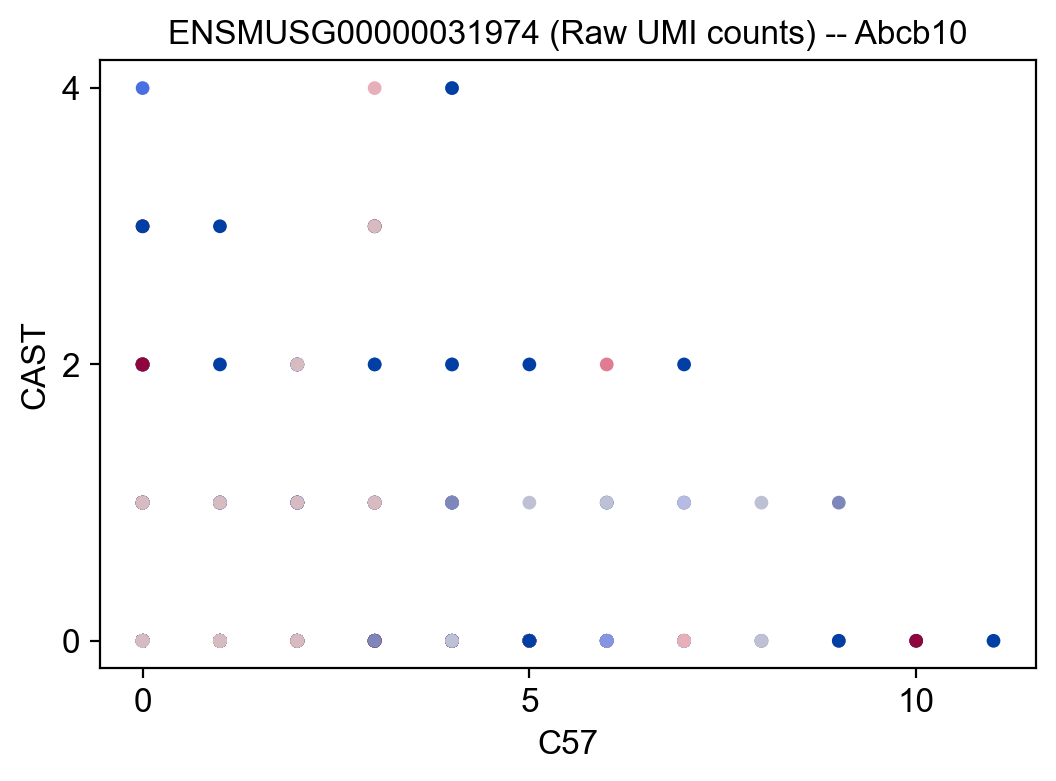

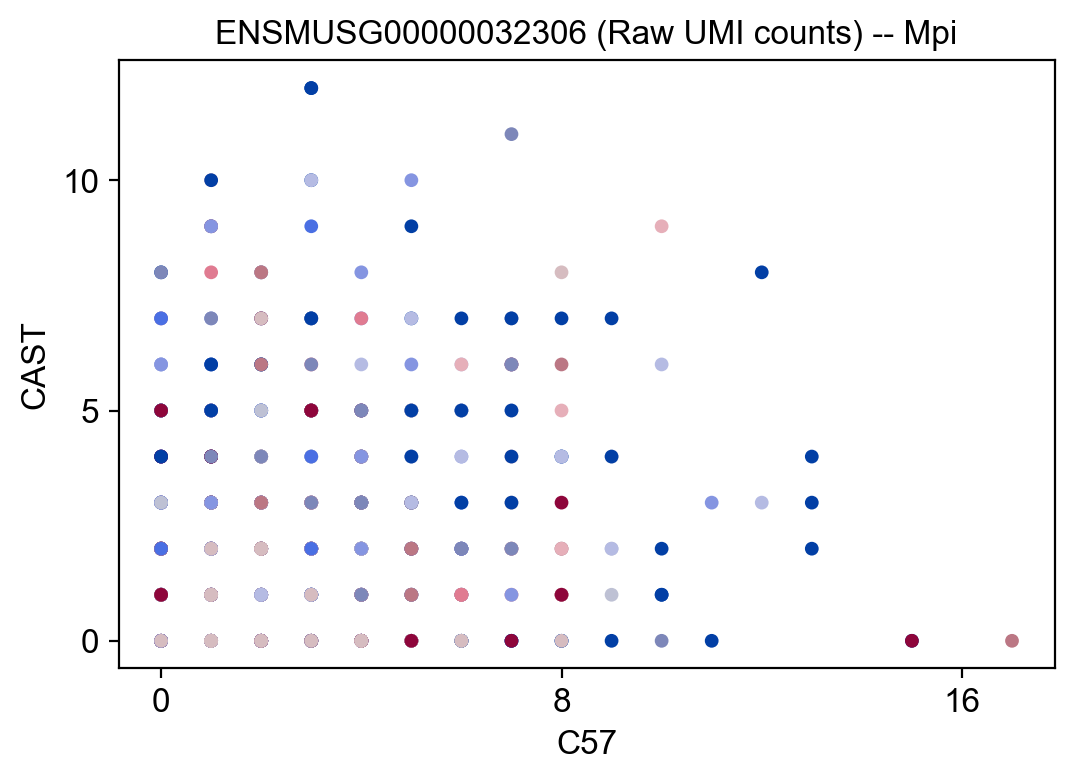

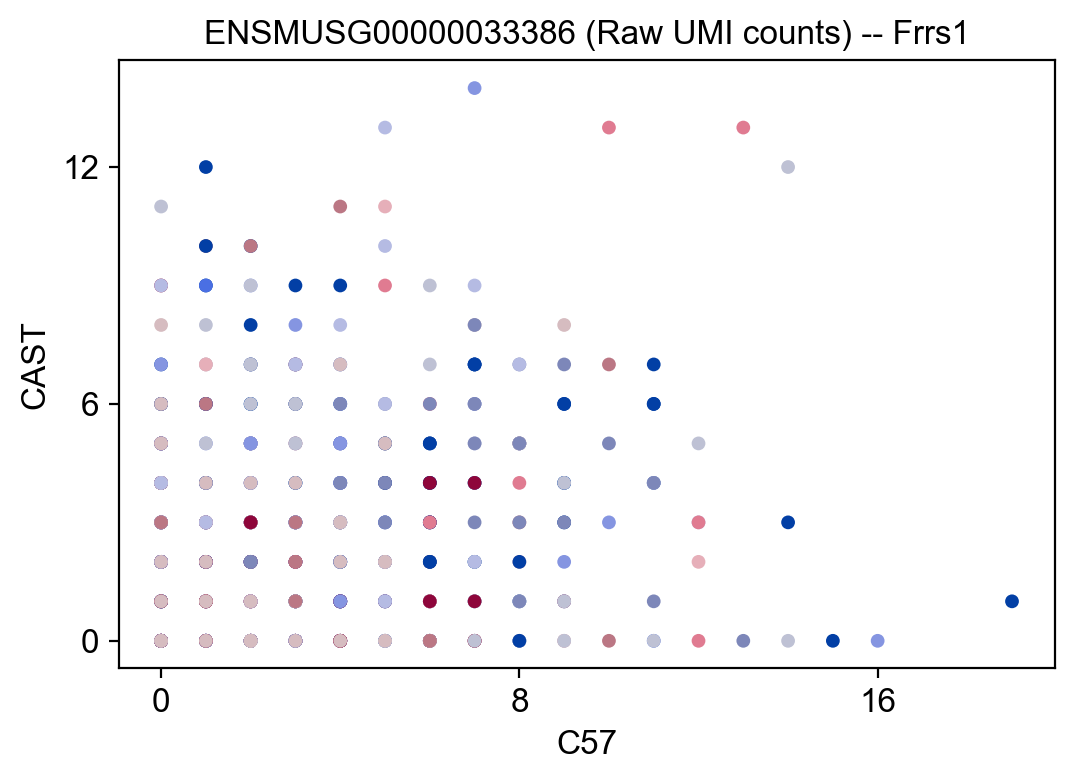

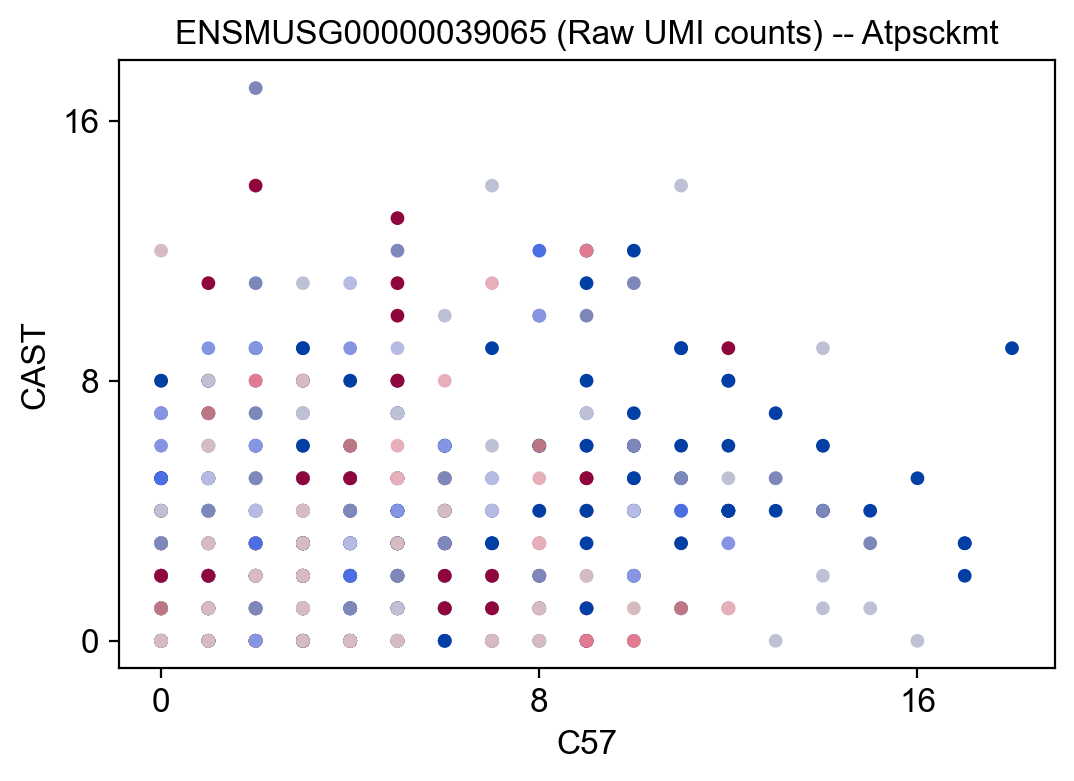

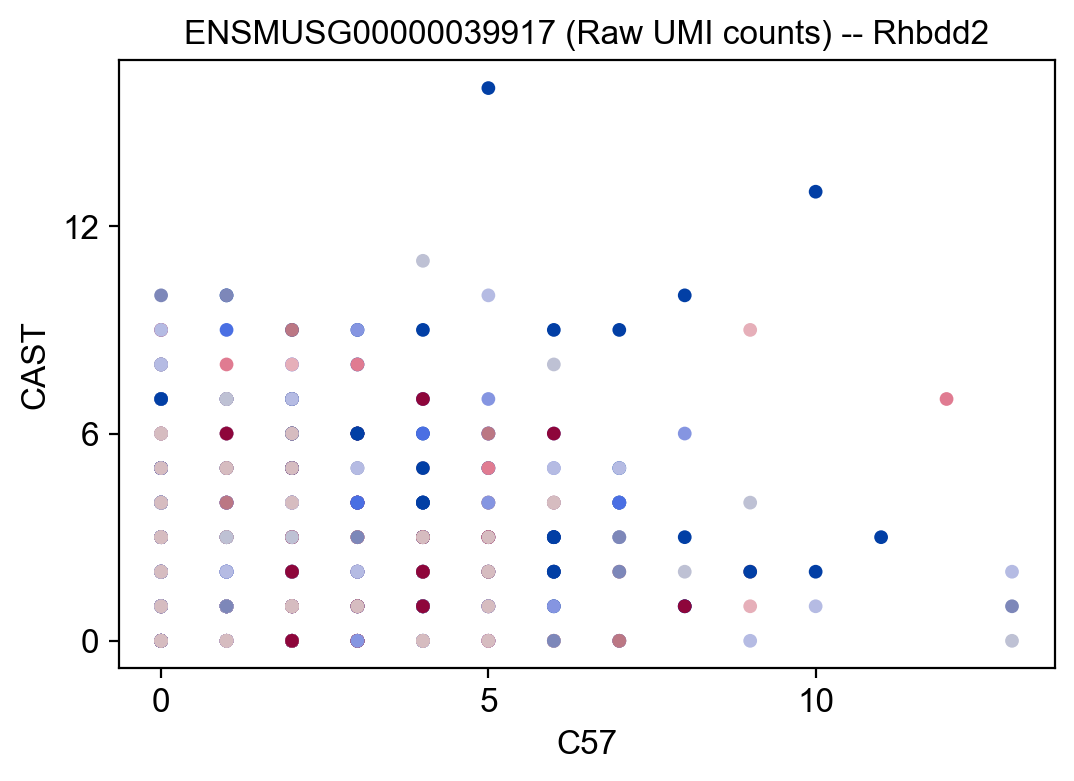

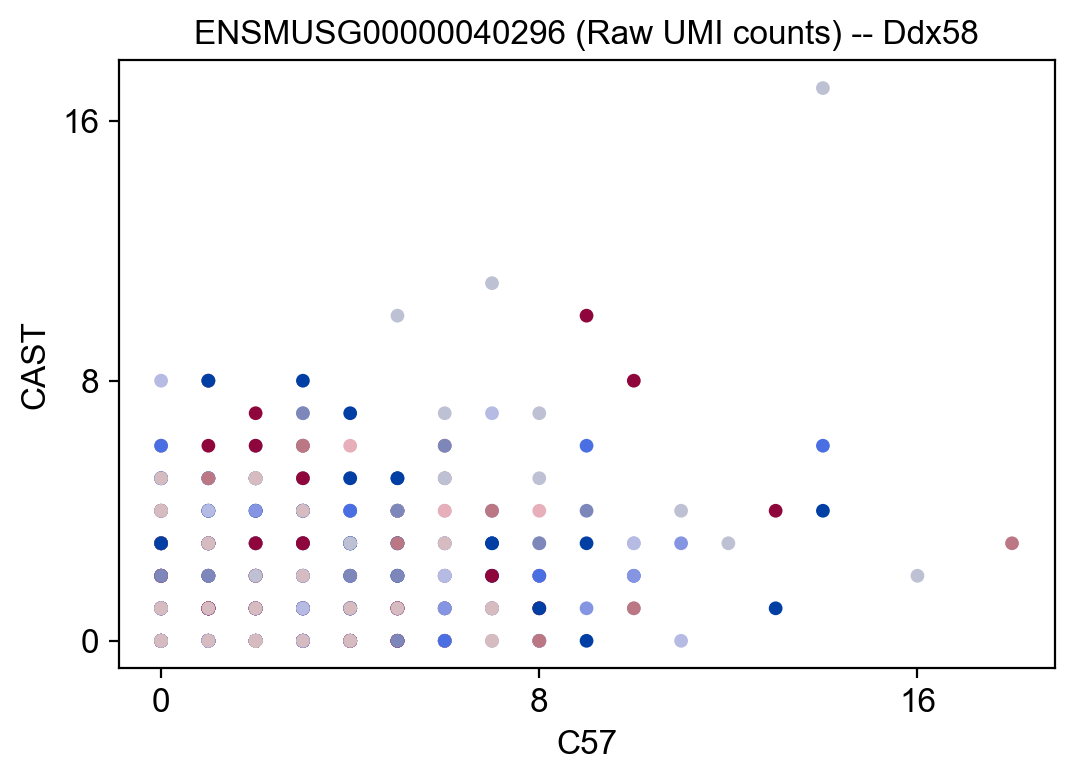

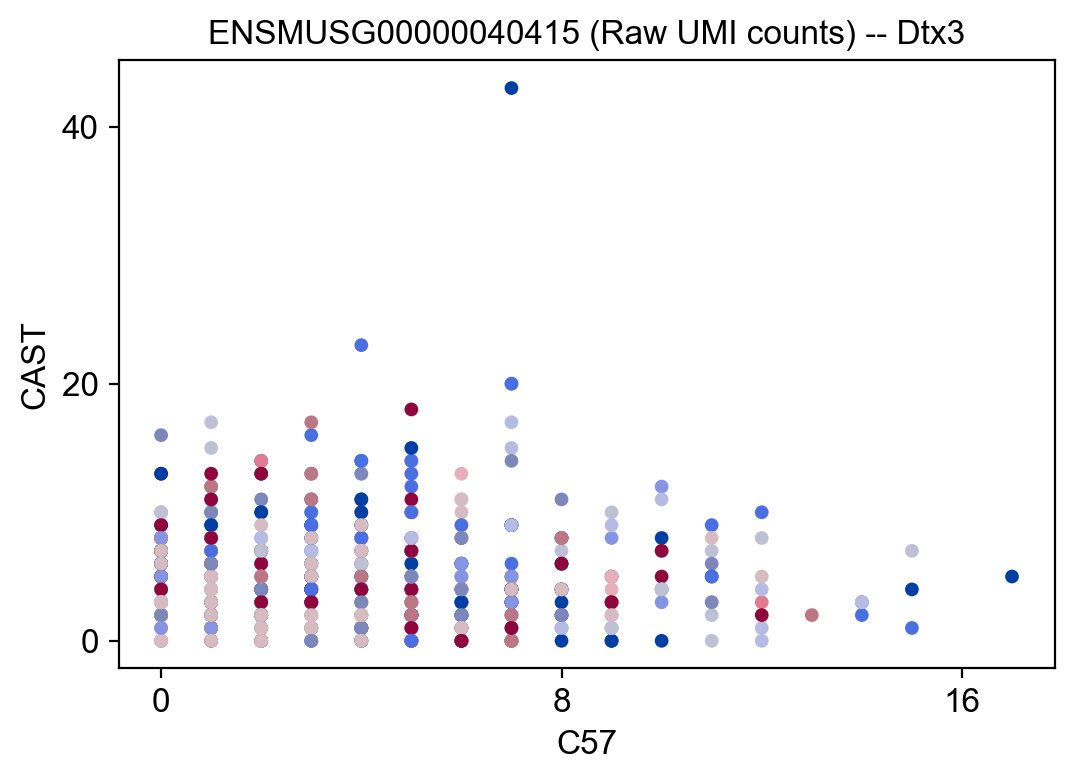

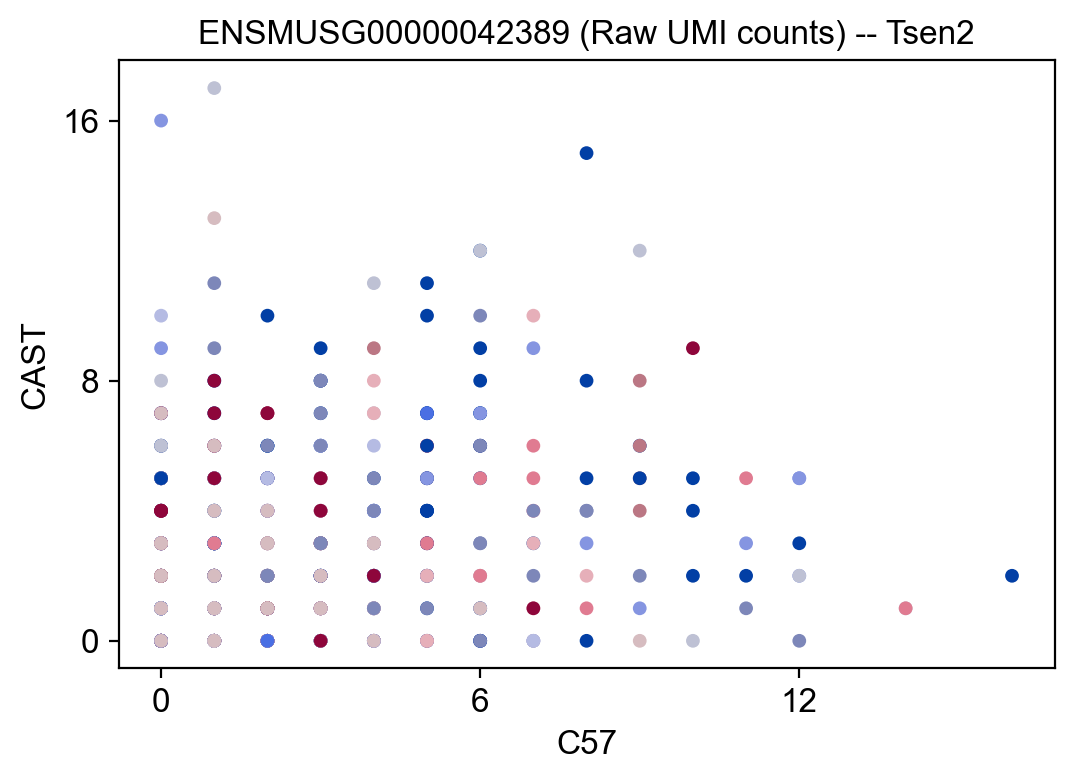

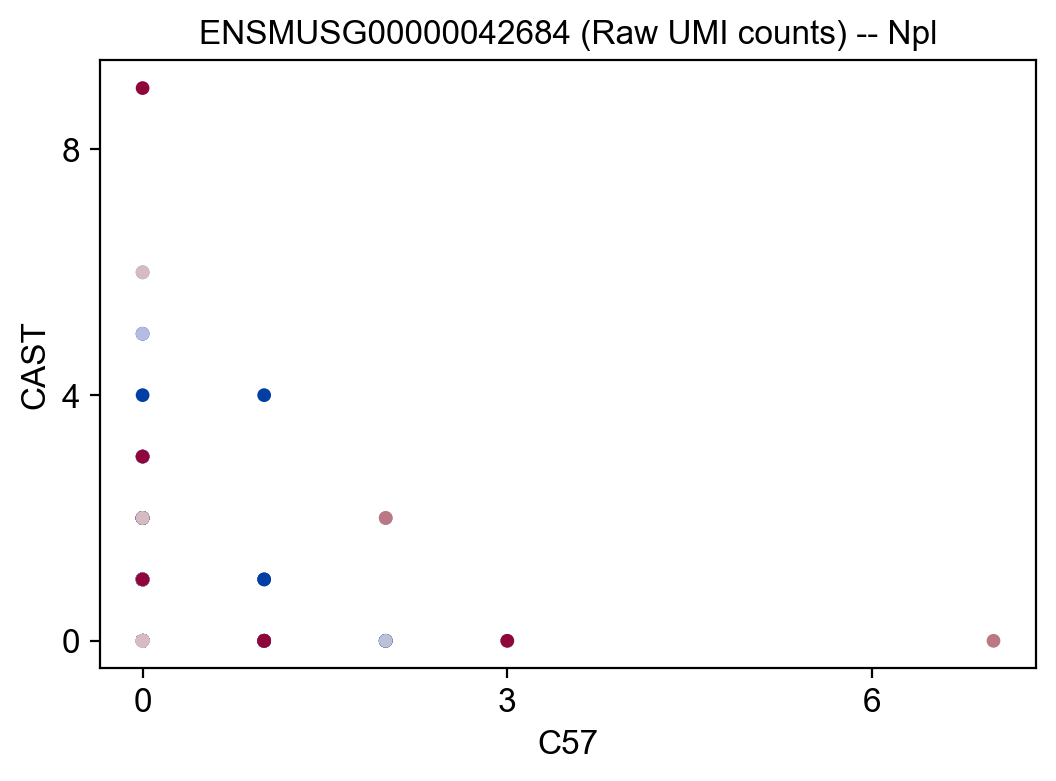

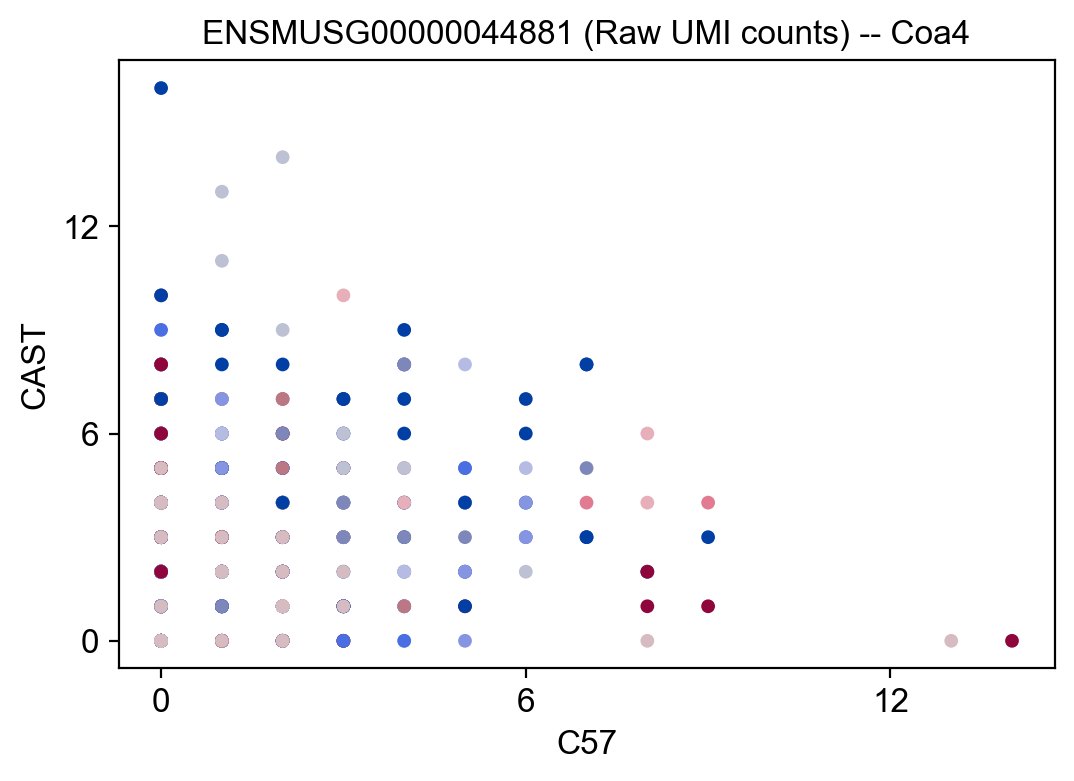

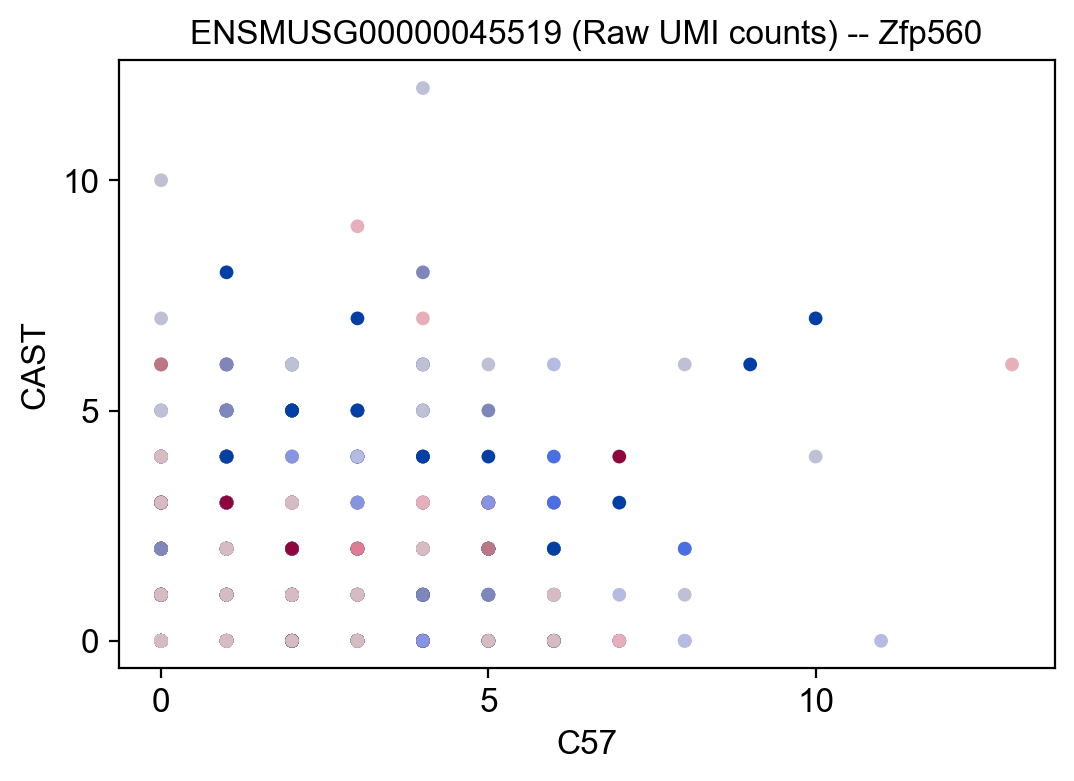

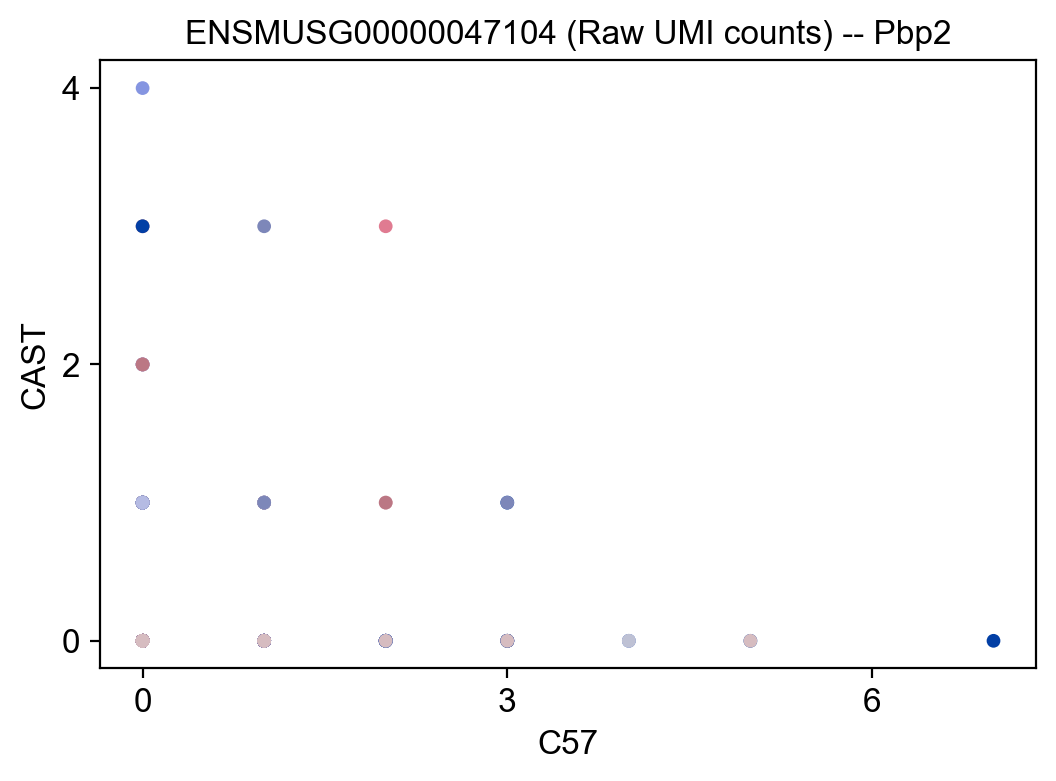

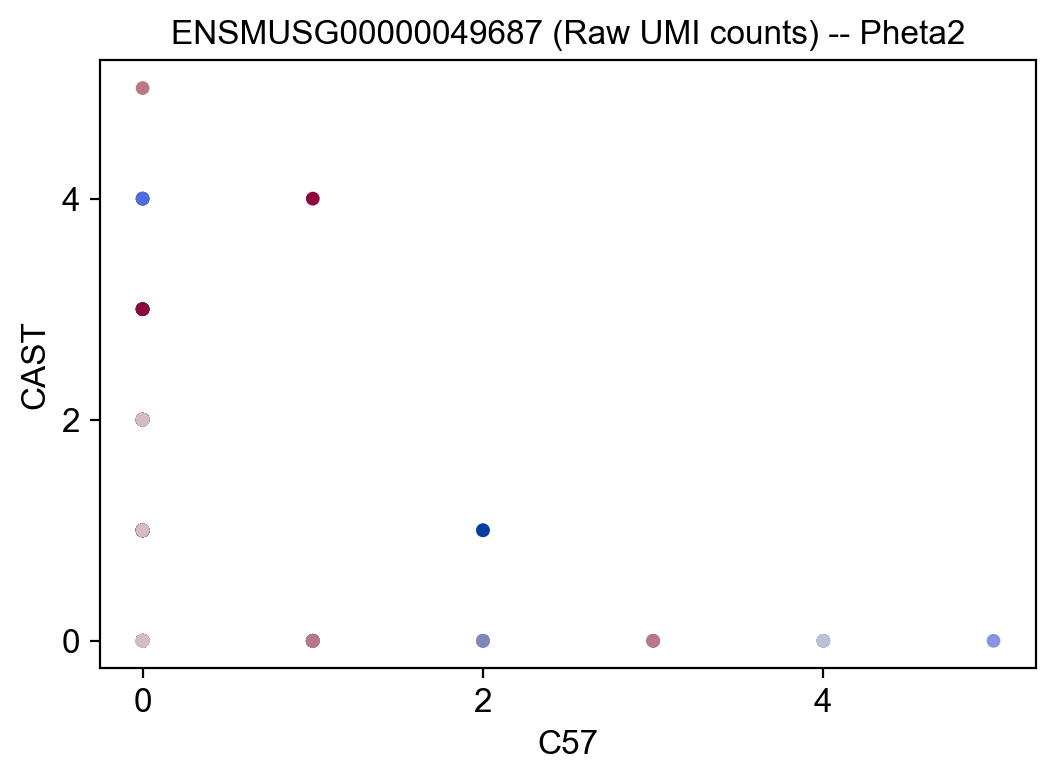

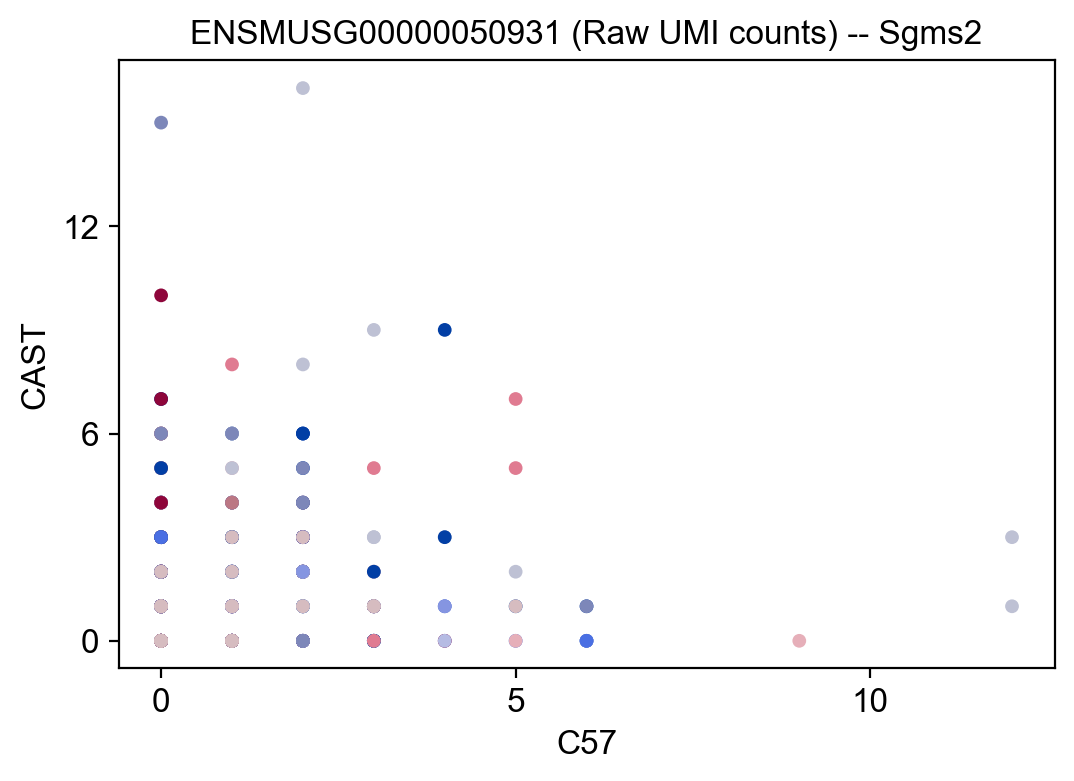

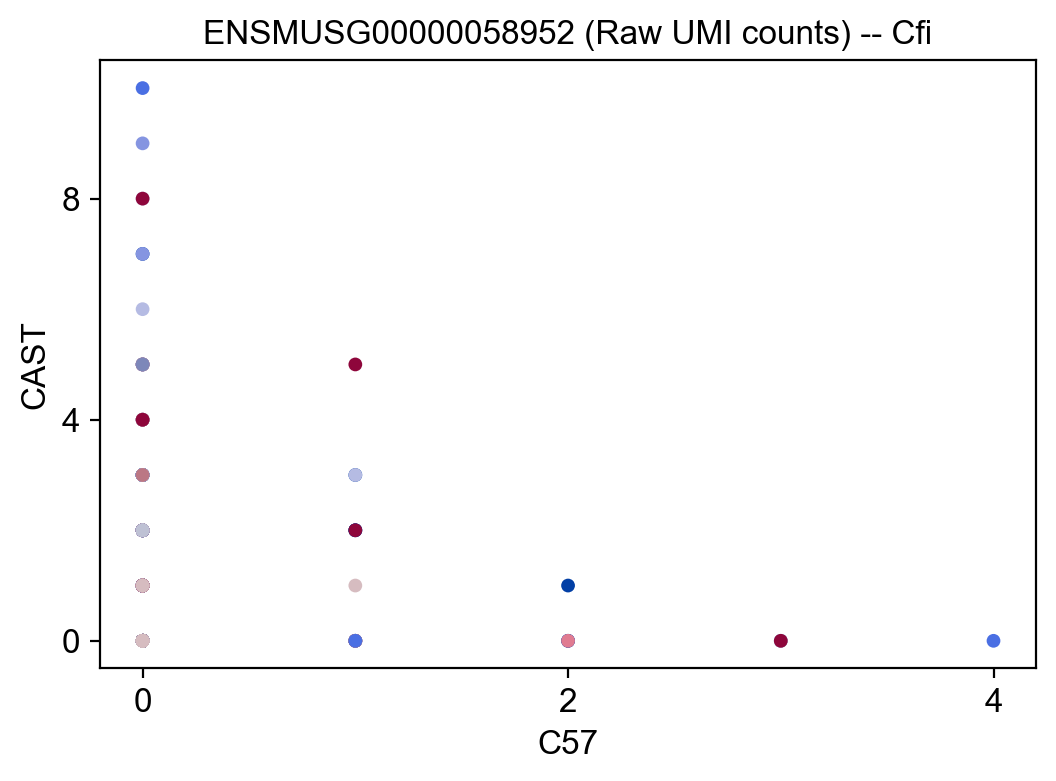

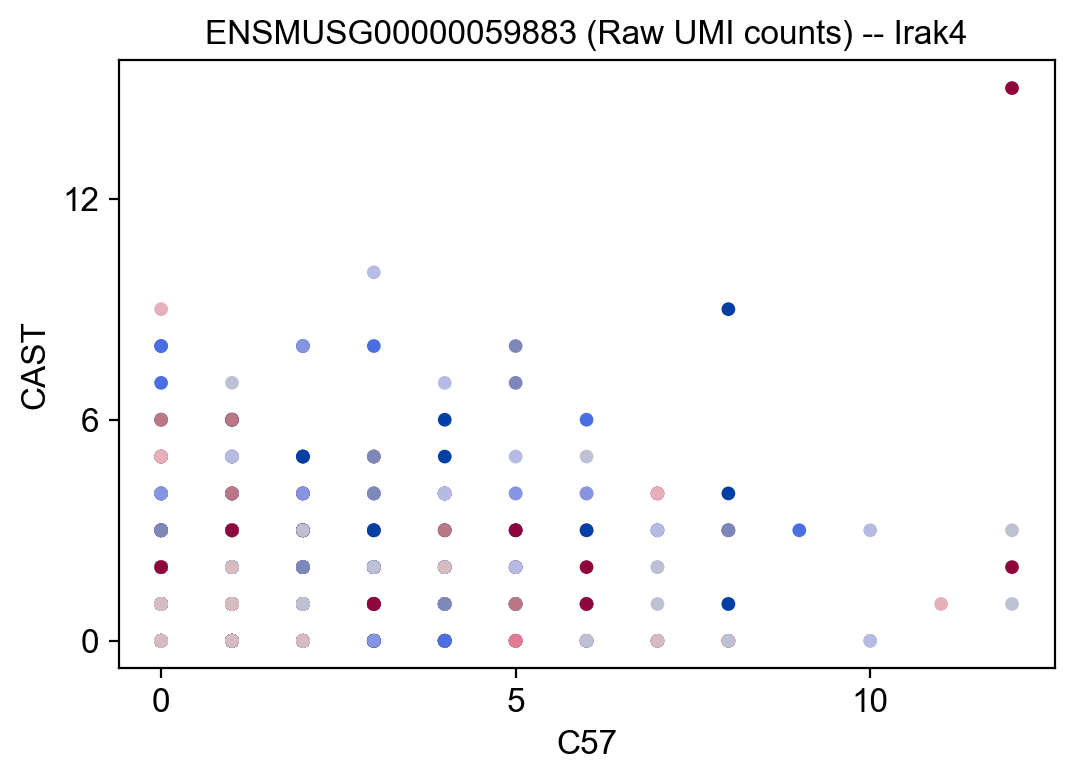

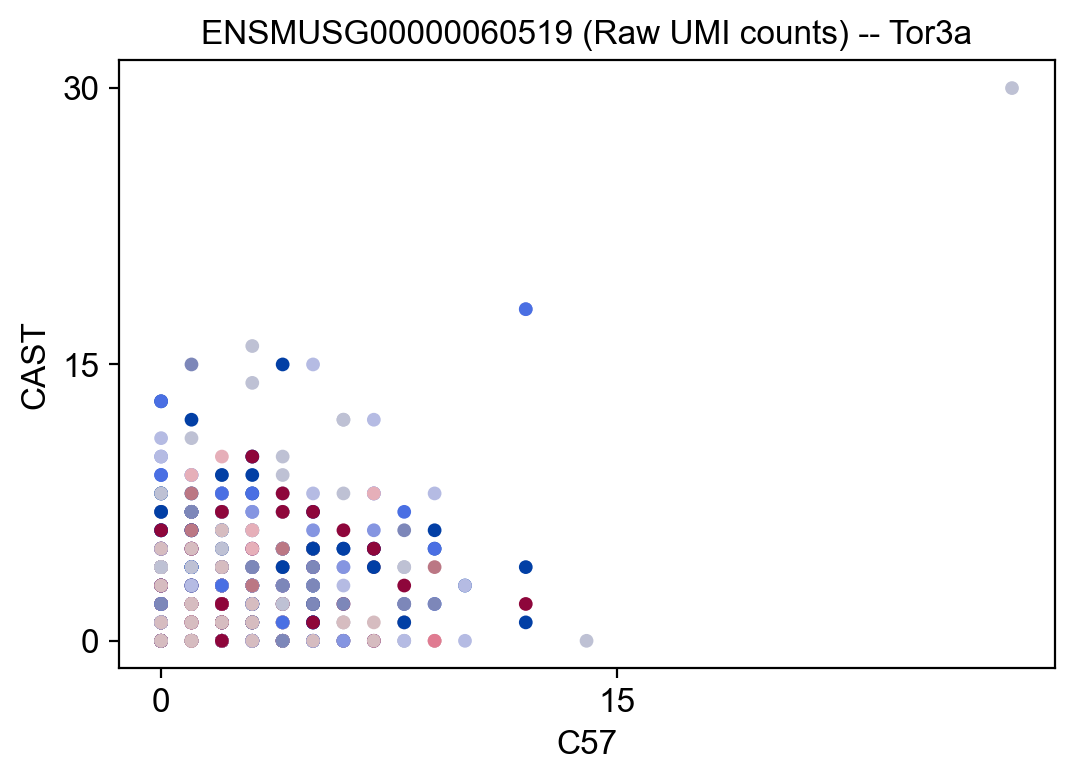

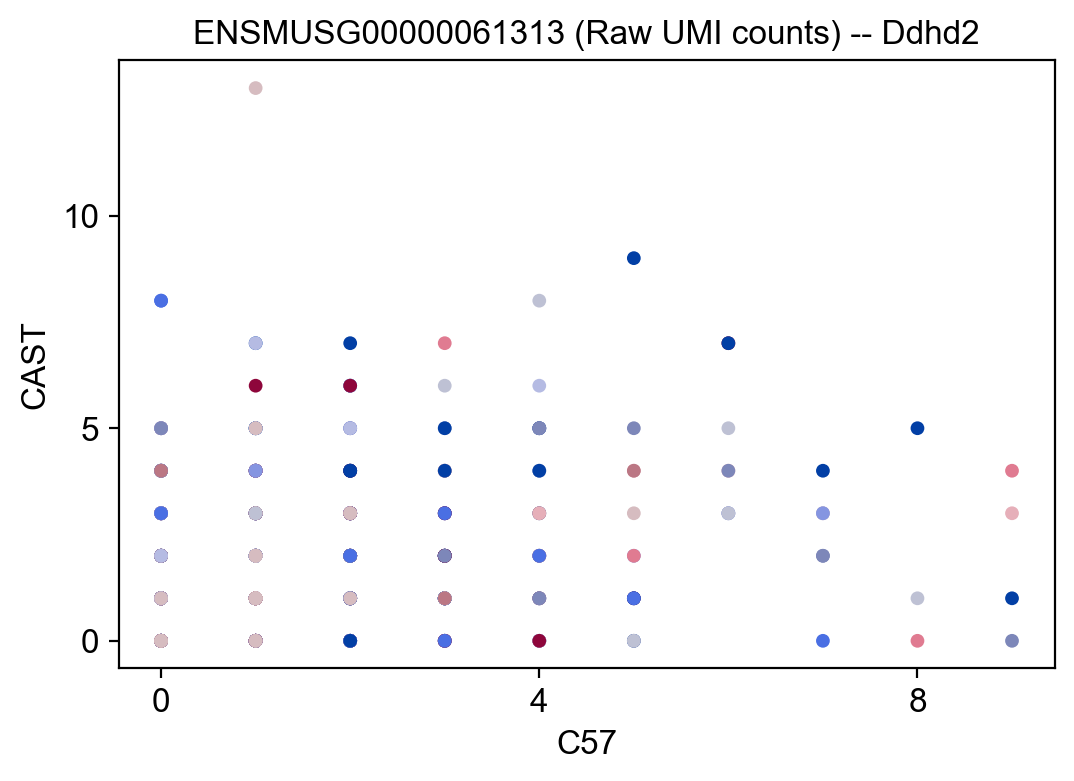

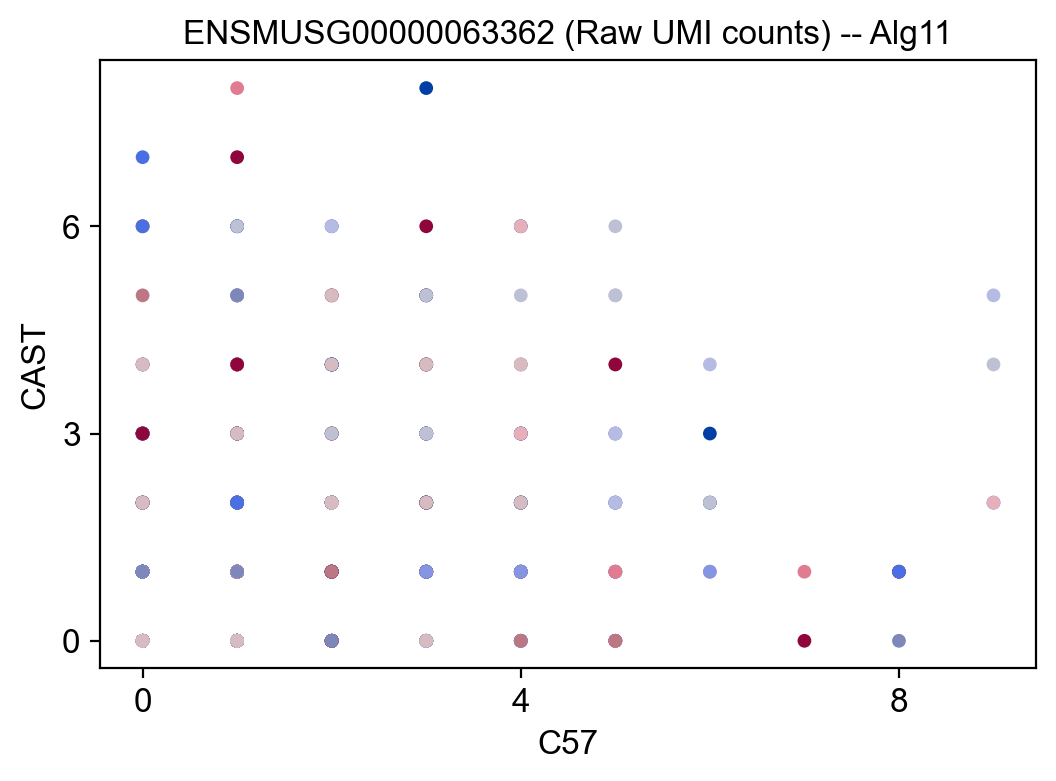

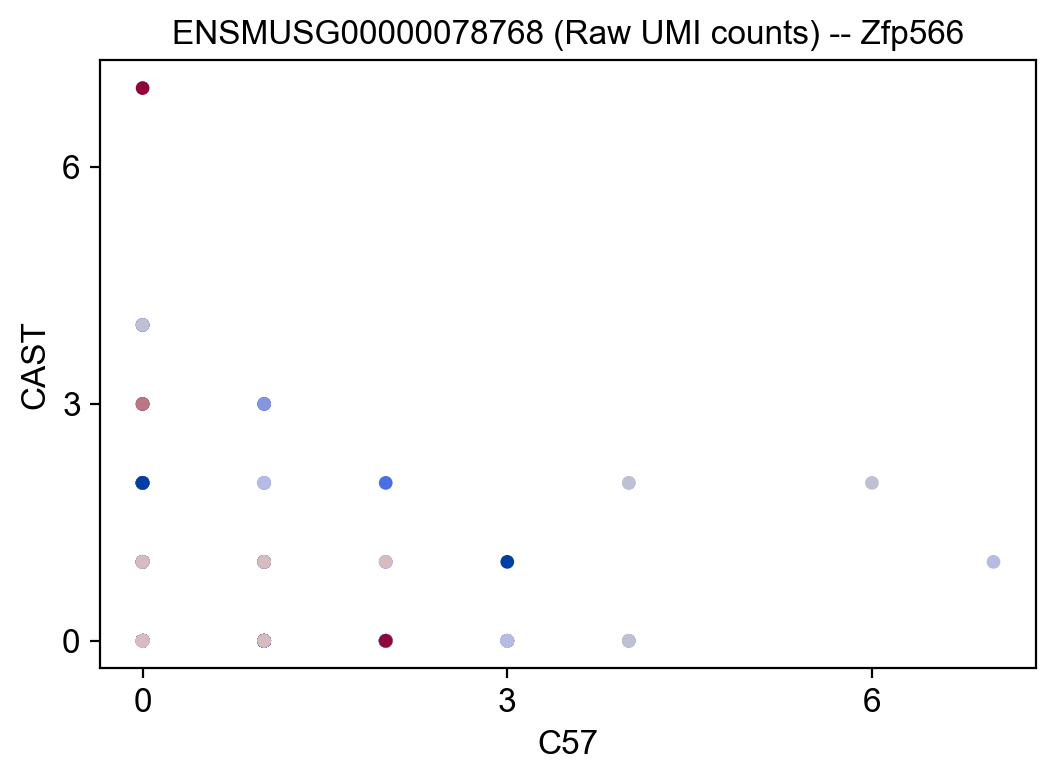

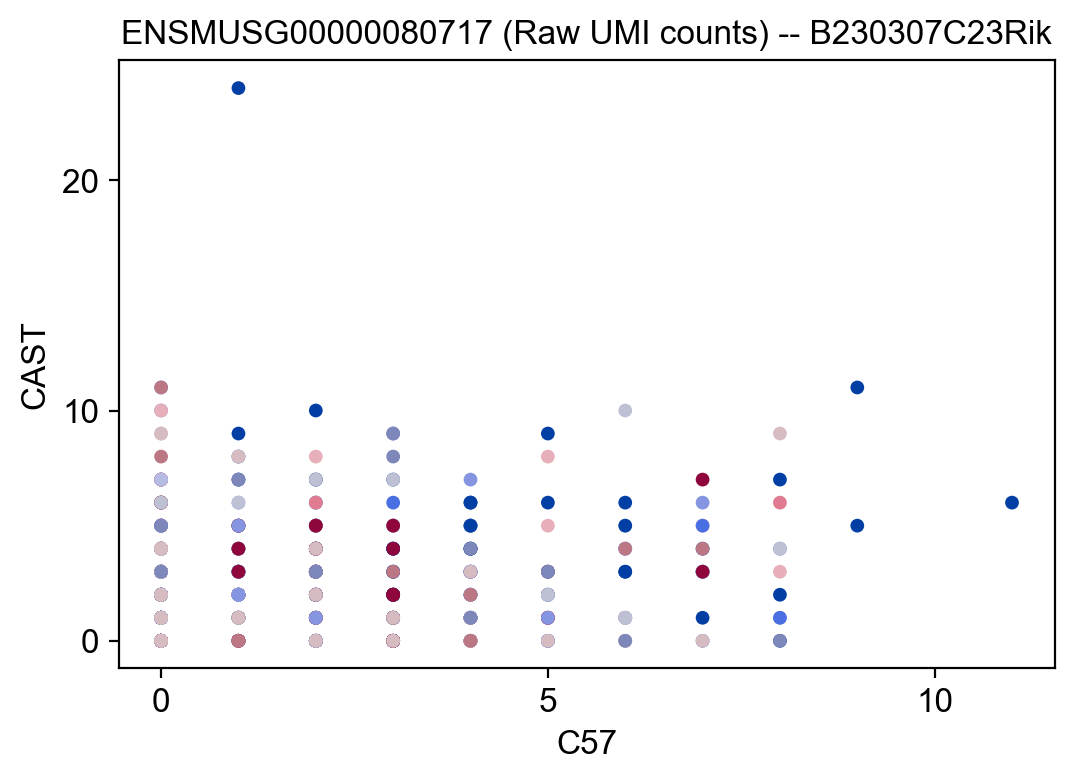

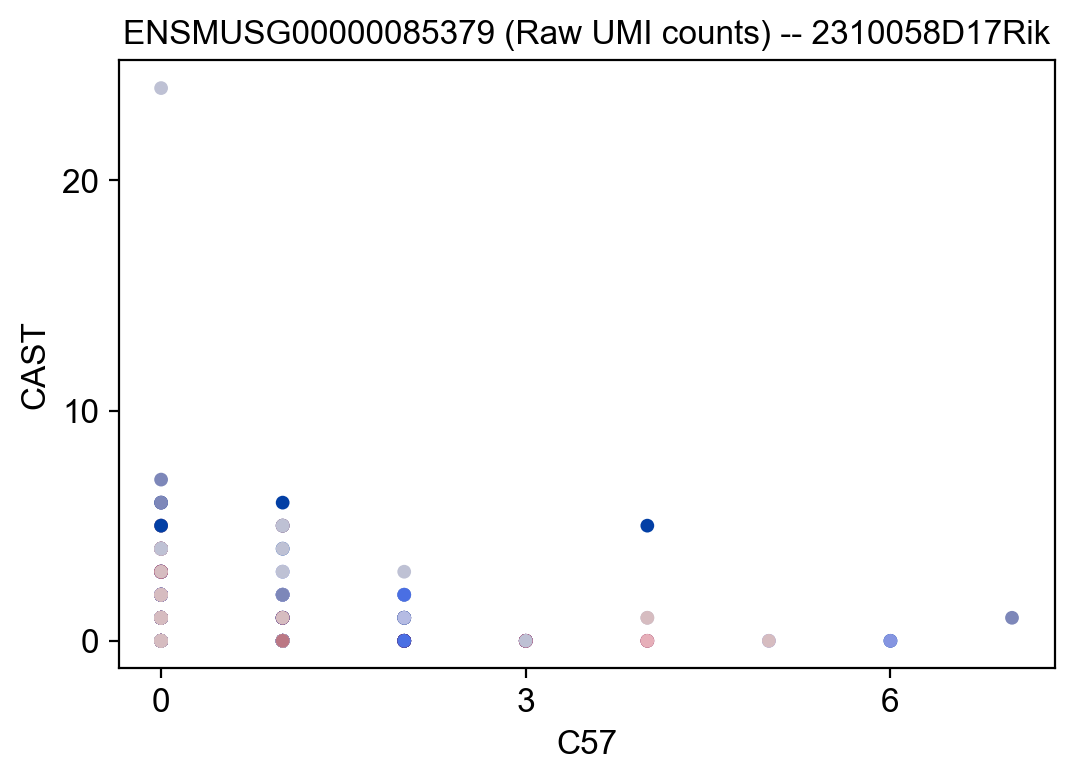

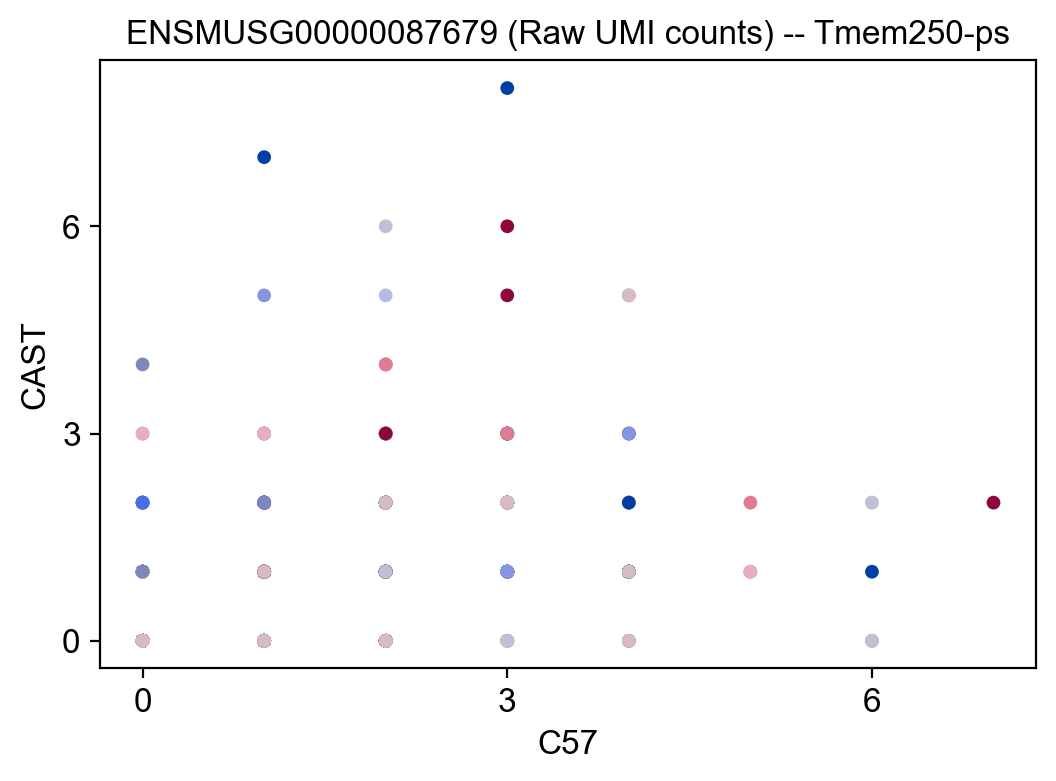

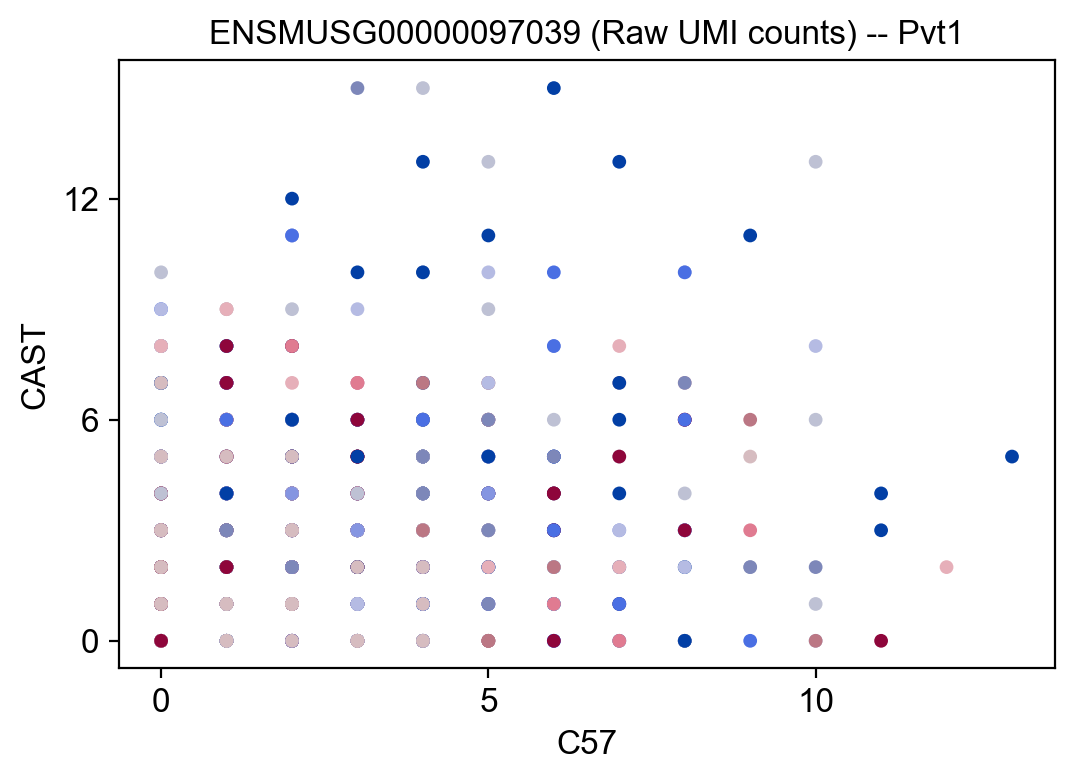

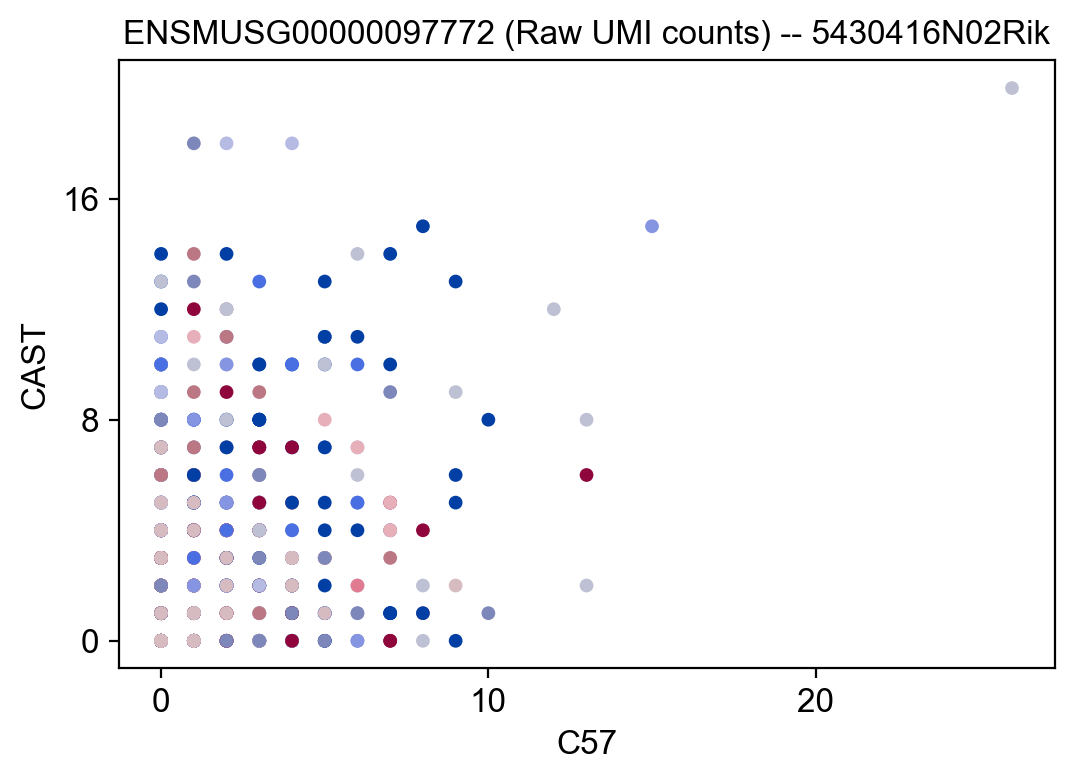

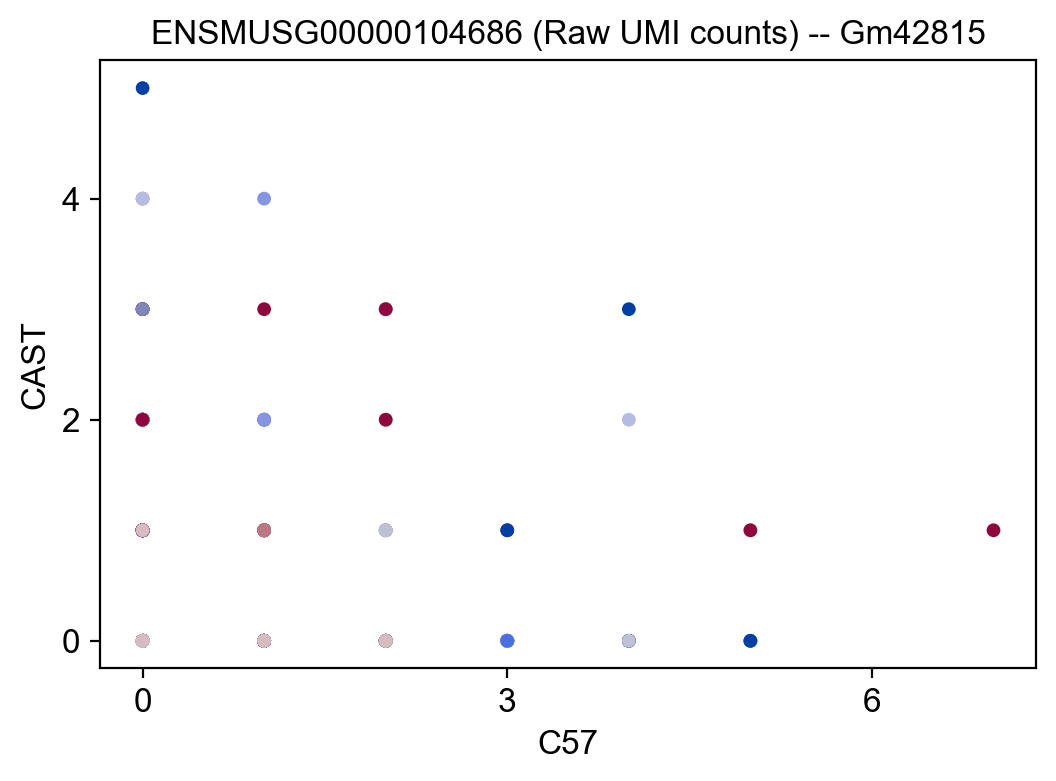

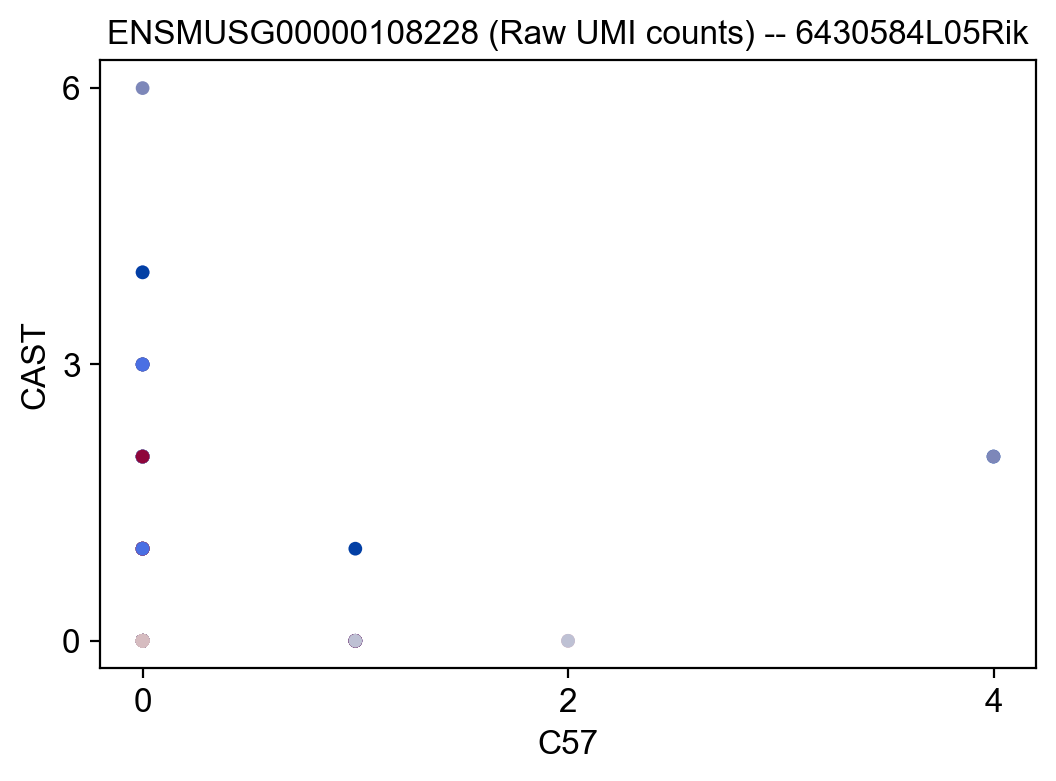

In [21]:
count = 1
for x in list(adata.var.index):
    if x in adata.var.index:
        scv.pl.scatter(adata, x, color=['clusters'], normalize_data= False,
                       xlabel='C57', ylabel='CAST', title=f"{x} (Raw UMI counts) -- {(adata.var.loc[x]['gene_name'])}")
        count += 1